## Characterizing mean timecourses per ROI

- This notebook contains the scripts to characterize node timecourses using various functions

- Code to fit mean timecourses for each node (1) across responses and (2) separately for yes/no responses

- Also I try to get optimal functions for yes/no responses per node on the mean data here

- Identifying best yes/no fits for each node

- TO DO : clean code a bit more, add more documentation

In [1]:
# RUN THIS CELL
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook
#data_file_loc = os.getcwd()

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", 
            "Random mechanical", "Scaring", "SEDUCING-B", "STAR-A", 
            "SURPRISING-B", "TENNIS-A"]

In [3]:
data_file_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data'

### Import timecourses

Text(0.5, 1.0, 'Node timecourses avged. across movies, subs')

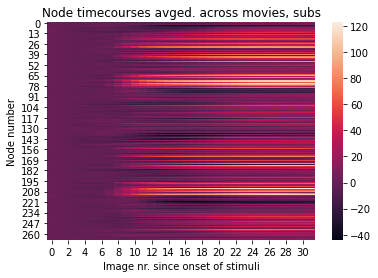

In [19]:
# Across all response types/9useful to get an initial idea of timecourses)

def get_mean_timecourses():
    # returns timeourses and means/means across all subs. 
    # doesn't take any inputs, but data_file_loc (location with movie timecourse) 
    # needs to be previously defined
    # each movie timecourse file has the dims: nsub*nnodes*ntimepts(43)
    nmovies = 10
    for movie_ind in range(nmovies):
        #fileName = os.path.join(data_file_loc,f'timecourse-movie{movie_ind}.npy')
        fileName = os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies.npy')
        movieTC = np.load(fileName) # nsubs * nnodes * ntimepts*nmovies
        movieTC = movieTC[:,:,:,movie_ind]
        if movie_ind == 0:
            movie_tc_all = np.zeros((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
        movie_tc_all[:,:,:,movie_ind] = movieTC # nsubs * nnodes * ntimepts * nmovies
    mean_tc = np.mean(movie_tc_all, axis = (0,3)) # averaged across subs and movies
    median_tc = np.median(movie_tc_all, axis = (0,3)) # averaged across subs and movies
    
    return movie_tc_all, mean_tc, median_tc

movie_tc_all, mean_tc, median_tc = get_mean_timecourses()
sns.heatmap(mean_tc)
plt.xlabel('Image nr. since onset of stimuli')
plt.ylabel('Node number')
plt.title('Node timecourses avged. across movies, subs')

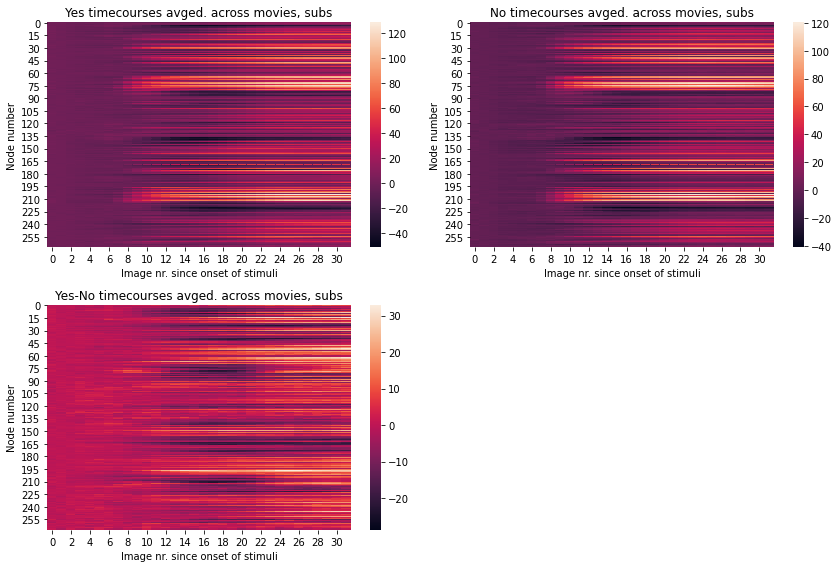

In [17]:
# RUN THIS CELL for actual yes vs. no comparisons
def get_mean_timecourses_respbased():
    # returns timeourses and means/medians of yes  and no responders separately. 
    # doesn't take any inputs, but data_file_loc (location with responseinfo and movie timecourse) 
    # needs to be previously defined
    # response file has a mat of dims nsub*nmovies
    # each movie timecourse file has the dims: nsub*nnodes*ntimepts(43)
    #responses = np.load(os.path.join(data_file_loc,'responses_slopereg.npy')) # subs*movies
    responses = np.load(os.path.join(data_file_loc,'responses.npy')) # subs*movies
    nmovies = 10
    for movie_ind in range(nmovies):
        fileName = os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies.npy')
        movieTC = np.load(fileName) # nsubs * nnodes * ntimepts*nmovies
        movieTC = movieTC[:,:,:,movie_ind]
        
        resp_yes = responses[:,movie_ind] == 1
        resp_no = responses[:,movie_ind] == 0
        resp_unsure = responses[:,movie_ind] == 9
        
        if movie_ind == 0:
            movie_tc_yes = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_no  = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_unsure  = np.empty((movieTC.shape[0],movieTC.shape[1],movieTC.shape[2],nmovies))
            movie_tc_yes[:] = np.nan
            movie_tc_no[:] = np.nan
            movie_tc_unsure[:] = np.nan
        
        movie_tc_yes[resp_yes,:,:,movie_ind] = movieTC[resp_yes,:,:] # fills out only yes rows
        movie_tc_no[resp_no,:,:,movie_ind] = movieTC[resp_no,:,:] # fills out only no rows
        movie_tc_unsure[resp_unsure,:,:,movie_ind] = movieTC[resp_unsure,:,:] # fills out only no rows
        # nsubs * nnodes * ntimepts * nmovies
    mean_tc_yes = np.nanmean(movie_tc_yes, axis = (0,3))
    mean_tc_no = np.nanmean(movie_tc_no, axis = (0,3))
    mean_tc_unsure = np.nanmean(movie_tc_unsure, axis = (0,3))
    median_tc_yes = np.nanmedian(movie_tc_yes, axis = (0,3))
    median_tc_no = np.nanmedian(movie_tc_no, axis = (0,3))
    median_tc_unsure = np.nanmedian(movie_tc_unsure, axis = (0,3))
    return movie_tc_yes, movie_tc_no, movie_tc_unsure, mean_tc_yes, mean_tc_no, mean_tc_unsure, median_tc_yes, median_tc_no, median_tc_unsure


movie_tc_yes, movie_tc_no, movie_tc_unsure,mean_tc_yes, mean_tc_no, mean_tc_unsure, median_tc_yes, median_tc_no, median_tc_unsure = \
    get_mean_timecourses_respbased()

plt.figure(1,figsize = (12,8))
plt.subplot(2,2,1)
sns.heatmap(mean_tc_yes)
plt.xlabel('Image nr. since onset of stimuli')
plt.ylabel('Node number')
plt.title('Yes timecourses avged. across movies, subs')

plt.subplot(2,2,2)
sns.heatmap(mean_tc_no)
plt.xlabel('Image nr. since onset of stimuli')
plt.ylabel('Node number')
plt.title('No timecourses avged. across movies, subs')

plt.subplot(2,2,3)
sns.heatmap(mean_tc_yes - mean_tc_no)
plt.xlabel('Image nr. since onset of stimuli')
plt.ylabel('Node number')
plt.title('Yes-No timecourses avged. across movies, subs')
# from last subplot: differences emerge later in all nodes

plt.tight_layout()

# Average across timecourses

In [18]:
responses = np.load(os.path.join(data_file_loc,'responses.npy')) # subs*movies
responses[:10,:]  

array([[nan,  0.,  1., nan, nan,  1.,  1.,  0.,  1.,  9.],
       [ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.],
       [ 1.,  9.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  9.],
       [ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  9.],
       [ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.]])

### Curve-fitting of nodes using lmfit

In this section, I explore which curves can best explain the temporal changes of nodes. Since cluster 0 in both cases also show a linear trend (special case of sigmoid), I try to fit both clusters with the same function. First I explore 3 functions' parameters below:
1. logistic function
2. sinusoidal function 
3. gaussian function

Other functions I tried but didn't use finally are at the end of the notebook

I use the lmfit package to fit the curves since it is robust and offers options to initialise, set bounds etc.

In [14]:
nfunctions = 4

from lmfit.models import StepModel, LinearModel, SineModel
#from lmfit import Models

# separately defining functions here for the first step. For later steps, use the functions in 
# fit_fns_fMRI.py

def logfit_fn(y,plot_fig=0):
    # computes the best fit using a logistic function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    from lmfit.models import StepModel
    import numpy as np
    import matplotlib.pyplot as plt
    
    #model = Model(logistic_function)#,nan_policy = 'omit') # set model here
    #model.set_param_hint('A', min=-1, max = 1) # set a parameter's range here
    #model.set_param_hint('c', min=2, max = 25)
    #model.set_param_hint('s', min=.1, max = 500)
    #params = model.make_params(c=np.argmax(np.diff(y)), 
    #                               A = max(y)-min(y), s = 1)  # set initial parameter value here
    
    model = StepModel(form='logistic') # set model here
    model.set_param_hint('amplitude', min=-1.5*(max(y)-min(y)), max = 1.5*(max(y)-min(y)))
    model.set_param_hint('center', min=4, max = 24)
    model.set_param_hint('sigma', min=.1, max = 10)
   
    params = model.make_params(amplitude=max(y)-min(y),
                               center=np.argmax(np.diff(y)),
                                   sigma = 1 )  # set initial parameter value here
    
    result = model.fit(y, params, x=np.arange(0,28))
    
        
    param_keys = list(result.best_values.keys()) # A,c,s for logisticfn
    param_keys.remove('form')
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test_fn(y, result.best_fit)
    
    if plot_fig:
        result.plot()
        plt.suptitle('Logistic,Rsq='+str(np.round(r2,2)),fontweight = 'bold')
    
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname] 
        
    return params_best,param_keys,r2,result.aic, result



def sinefit_fn(y,plot_fig=0):
    # computes the best fit using a sinusoidal function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    from lmfit.models import SineModel
    import numpy as np

    import matplotlib.pyplot as plt
    
    from scipy.signal import find_peaks
    
    model = SineModel() # set function here
    
    model.set_param_hint('amplitude', min = 1e-3,max = 1) # set param range here
    model.set_param_hint('frequency', min = .5, max = 3)
    
    peak,_ = find_peaks(np.abs(y),height= max(np.abs(y))/2)
    #print(peak)
    if len(peak) > 0:
        if y[peak[0]] > 0:
            ph = 0
        else:
            ph = np.pi
        init_amp = abs(y[peak[0]])
        init_freq =  len(peak)/2
    else:
        ph = 0
        init_amp = .5
        init_freq =  1
    
    params = model.make_params(amplitude = init_amp, frequency = init_freq,
                               shift = ph ) # set initial param values here
    #y = y[5:]
    #print('y=',y,'\namp init=',max(y, key=abs))
    result = model.fit(y, params, x=np.linspace(0,2*np.pi,len(y)))
    param_keys = list(result.best_values.keys()) # E.g. A,freq,ph
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test_fn(y, result.best_fit)
    if plot_fig:
        result.plot()
        plt.suptitle('Sinusoidal, Rsq='+str(np.round(r2,2)),fontweight = 'bold')
    #print(result.best_values)
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname]
        
    return params_best,param_keys, r2, result.aic, result



def gaussianfit_fn(y,plot_fig=0):
    # computes the best fit using a gaussian function (for early peak-timecourses) for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    from lmfit.models import GaussianModel
    import numpy as np
    import matplotlib.pyplot as plt
    
    
    model = GaussianModel()  # set model here
    
    if y[np.argmax(np.abs(y))] < 0:
        minval = -2*np.pi*5*(max(y)-min(y))
        maxval = -1e-10
        #maxval = -2*np.pi*5*(max(y)-min(y))/10
        init_amp = -2*np.pi*max(np.abs(y))
    else:
        #minval = 2*np.pi*5*(max(y)-min(y))/10
        minval = 1e-10
        maxval = 2*np.pi*5*(max(y)-min(y))
        init_amp = 2*np.pi*max(np.abs(y))
    
    model.set_param_hint('amplitude', min=minval, max = maxval) # set parameter ranges here
    model.set_param_hint('center', min = 3, max = 25)
    model.set_param_hint('sigma', min=.1, max = 10)
    
    params = model.make_params(amplitude = init_amp, center = np.argmax(np.abs(y)),
                               sigma = 1) # set initial param values here
    
    result = model.fit(y, params, x=np.arange(0,28))
    param_keys = list(result.best_values.keys()) # E.g. A,freq,ph
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test_fn(y, result.best_fit)
    if plot_fig:
        result.plot()
        plt.suptitle('Gaussian, Rsq='+ str(np.round(r2,2)),fontweight = 'bold')    
    #print(result.best_values)
    
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname]
        
    return params_best,param_keys, r2, result.aic, result

def delayed_sin(x, step_onset, amp, freq, phase):
#def delayed_sin(x, step_size = .01, step_onset = 5, amp=.5, freq=1, phase=3.14):
    import numpy as np
    y = np.zeros((len(x),))
    nonzero_ind = np.arange(int(step_onset),len(x))
    for i in nonzero_ind: # e.g. 5 to 28
        if np.round(phase*100)-np.round(np.pi*100)<1:
            y[i] = amp * np.sin(freq*(x[i]-x[nonzero_ind[0]])+phase)
        # print(y[i])
    return y
    
def stepsine_fn(y, plot_fig=0):

    from lmfit.models import Model
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import find_peaks
    
    model = Model(delayed_sin)
    #model.set_param_hint('step_size', min=  -.2, max = .2)
    
    factor = 10 # arbitrary yoffset threshold. If i<maxdelay and y(i) < max(y)/factor, they're considered
    maxdelay = 8 # the delay is usually < 6 TRs based on manual examination
    
    peak,_ = find_peaks(np.abs(y),height= max(np.abs(y))/4) # return peak locations
    #print(peak)
    if len(peak) > 0:
        if y[peak[0]] > 0:
            ph = 0
        else:
            ph = np.pi
        init_amp = max(abs(y))
        
    else:
        ph = 0
        init_amp = .5
        
    init_freq =  1
    # to set the initial step_onset value. Thresholds are a bit arbitrary based on eyeballing the mean curves.
    # can change if there's a more objective way of doing this.
    
    
    model.set_param_hint('step_onset', min=2, max = maxdelay)
    model.set_param_hint('amp', min=1e-3, max = max(y)-min(y))
    model.set_param_hint('freq', min=.5, max = 2.5)
    model.set_param_hint('phase', min=0, max = np.pi)
    #sum_is = [sum(y[0:i]) for i in len(y)]
    # to determine if the first big peak is positive or negative
    #print('init:',i,init_amp,init_freq,ph)
    
    params = model.make_params(step_onset=3, amp = init_amp, freq = init_freq, phase = ph)

    result = model.fit(y, params, x=np.linspace(0,2*np.pi,28))
    param_keys = list(result.best_values.keys()) # E.g. A,freq,ph
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test_fn(y, result.best_fit)
    if plot_fig:
        result.plot()
        plt.suptitle('Step sine, Rsq='+ str(np.round(r2,2)),fontweight = 'bold')    
    #print(result.best_values)
    
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname]
        
    return params_best,param_keys, r2, result.aic, result



In [15]:
def function_fits(mean_tc):
    # function to test various curves' fits. returns fit-goodness metrics (rsq and aic) of all curves
    # input params: mean_tc (nodes*timept), r2_thr: rsq threshold,
    # resp_any: a subject*movies matrix of responses (1=yes,0=no,9=unsure, -1=no response)
    # node_plot: node nr to be plotted (1-268), 0 for not plotting
    # movie_plot: movie_ind to be plotted, -1 for not plotting
    
    
    params_array = np.empty((268,22)) # 3*3(sig,gau)+5(stepsin)+4(rsq)+4(aic)+1(node)
    params_array[:] = np.nan
            
    for fn in range(nfunctions):# find best-fitting function
        print('fn:',fn)
        for node in range(268):
            if fn == 0:
                params_best,param_keys,r2,aic,_ = logfit_fn(mean_tc[node,:])
            elif fn == 1:
                params_best,param_keys,r2,aic,_ = sinefit_fn(mean_tc[node,:])
            elif fn == 2:
                params_best,param_keys,r2,aic,_ = gaussianfit_fn(mean_tc[node,:])
            elif fn == 3:
                params_best,param_keys,r2,aic,_ = stepsine_fn(mean_tc[node,:])
            
            if fn < 3:
                cols = fn*3+np.arange(3)
            else:
                cols = fn*3+np.arange(4)

            params_array[node,cols] = params_best
            params_array[node,fn+13] = r2
            params_array[node,fn+17] = aic
            params_array[node,21] = node
            
    return params_array # cols 0-13:params,14-17:rsq, 18-21: aic, 22: node_ind

In [16]:
# getting rsq values for the mean curves across movies (to be replaced in the future by getting an average
# timecourse across movies and then fitting it)

#del df_modelfits # run if needed
dat = []

r2_thr = .3

colnames = ['f0param1','f0param2','f0param3','f1param1','f1param2','f1param3',
            'f2param1', 'f2param2','f2param3', 'f3param1','f3param2','f3param3', 'f3param4',
            'Rsq_Logistic', 'Rsq_Sinusoidal', 'Rsq_Gaussian','Rsq_Stepsin',
            'AIC_Logistic', 'AIC_Sinusoidal', 'AIC_Gaussian','AIC_Stepsin',
            'Nodes']

_, mean_tc,median_tc = get_mean_timecourses()
params_array = function_fits(mean_tc[:,3:-1])

df = pd.DataFrame(params_array,columns = colnames) 
df.head()

fn: 0
fn: 1
fn: 2
fn: 3


f0param1   f0param2  f0param3  f1param1  f1param2  f1param3    f2param1  \
0  11.235526  16.716794  1.416922  0.869752  2.550642 -5.951787  153.271476   
1  13.742072  15.779712  5.098757  0.742499  2.973731 -3.048943  272.147008   
2   2.020500  23.997926  1.129022  1.000000  0.500000  3.141593  -60.330053   
3   5.689781  13.539451  2.179238  0.975619  2.807144 -1.720439  125.041591   
4 -31.467145   7.957809  0.733905  0.012733  0.562366  6.243411 -694.638887   

    f2param2  f2param3  f3param1  ...  f3param4  Rsq_Logistic  Rsq_Sinusoidal  \
0  23.435305  4.959550       3.0  ...  3.141592      0.929387       -0.000898   
1  25.000000  9.447263       3.0  ...  0.168197      0.947687        0.058035   
2  11.978195  3.371630       3.0  ...  3.038169      0.166006        0.173385   
3  23.322603  7.457830       3.0  ...  3.132716      0.917379        0.038647   
4  17.504569  7.386342       3.0  ...  3.047236      0.937215       -0.000261   

   Rsq_Gaussian  Rsq_Stepsin  AIC_Logistic  AIC_Sinusoidal  AIC_Gaussian  \
0      0.921028     0.780820     45.016363      113.065824     47.373218   
1      0.945861    -0.016268      4.063795      116.065153      4.967139   
2      0.920017     0.831612     73.829440       65.331154     -1.765560   
3      0.937972     0.485000     -3.833328       84.845593    -10.685759   
4      0.814909     0.885337     77.459445      188.548716    107.988081   

   AIC_Stepsin  Nodes  
0    88.841919    0.0  
1   118.580637    1.0  
2    17.650297    2.0  
3    80.113883    3.0  
4    96.268836    4.0  

[5 rows x 22 columns]

In [17]:
#np.set_printoptions(precision=3)
#pd.set_option('precision', 3)
r2_thr

0.3

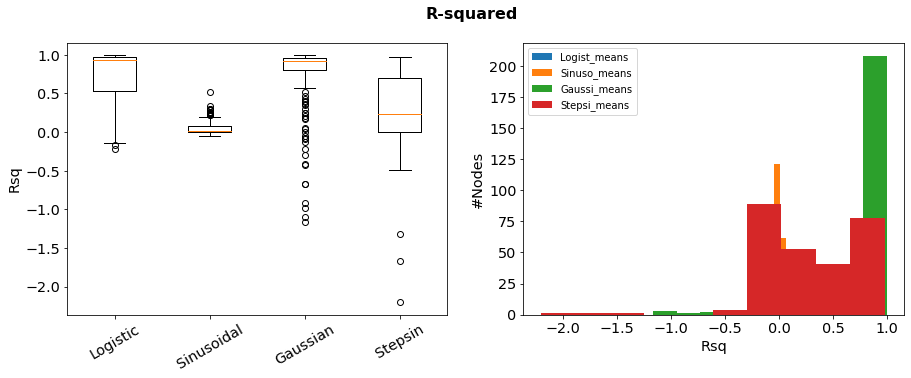

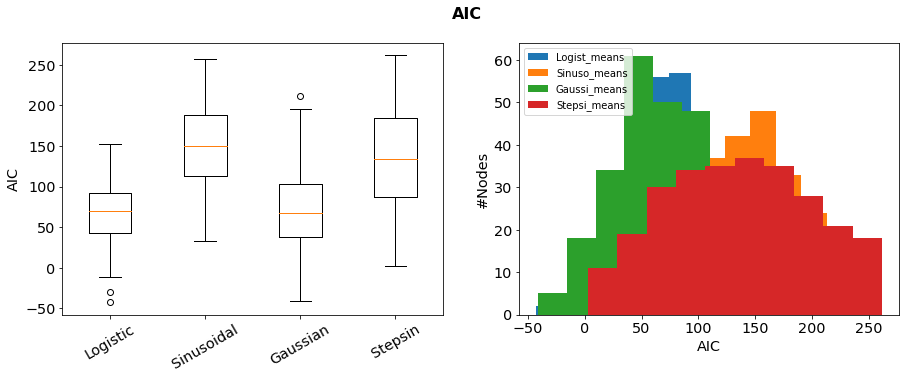

In [20]:
# plotting functionwise fit metrics (rsq and aic)

plt.figure(1,figsize = (15,5))
plt.suptitle('R-squared',fontsize = 16, fontweight = 'bold')
cols = [col for col in df if col.startswith('Rsq')]
plt.subplot(1,2,1)
plt.boxplot(df[cols].values)

plt.ylabel ("Rsq", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
lbls = [i[4:] for i in cols]
plt.xticks(np.arange(1,len(cols)+1),lbls,fontsize='x-large', rotation = 30)
#plt.legend(loc = 'lower left')

plt.subplot(1,2,2)
for colname in cols:
    plt.hist(df[colname].values,label = colname[4:10] + '_means')
plt.ylabel ("#Nodes", fontsize = 'x-large')
plt.xlabel ("Rsq", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.legend(loc = 'upper left')


plt.figure(2,figsize = (15,5))
plt.suptitle('AIC', fontsize = 16, fontweight = 'bold')
plt.subplot(1,2,1)
cols = [col for col in df if col.startswith('AIC')]
plt.boxplot(df[cols].values)
   
plt.ylabel ("AIC", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(np.arange(1,len(cols)+1),lbls,fontsize='x-large', rotation = 30)
#plt.legend(loc = 'lower left')

plt.subplot(1,2,2)
for colname in cols:
    plt.hist(df[colname].values,label = colname[4:10] + '_means')
plt.ylabel ("#Nodes", fontsize = 'x-large')
plt.xlabel ("AIC", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.legend(loc = 'upper left')

In [21]:
pd.set_option('display.max_colwidth', None) # so columns are not snipped

# loading the Shen atlas labels
shen268 = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268.head()

1  \
0  {'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}   

                                                                                                                                            2  \
0  {'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}   

                                                                                                                                          3  \
0  {'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}   

                                                                                                                                        4  \
0  {'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}   

                                                                                                                                                                                                            5  \
0  {'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}   

                                                                                                        6  \
0  {'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}   

                                                                                                         7  \
0  {'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}   

                                                                                                         8  \
0  {'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}   

                                                                                                         9  \
0  {'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}   

                                                                                                                                                     10  \
0  {'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}   

   ...  \
0  ...   

                                                                                                                                                                                                                              259  \
0  {'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}   

                                                                                                                                                            260  \
0  {'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}   

                                                                                                        261  \
0  {'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}   

                                                                                                                                             262  \
0  {'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}   

                                                                 

In [26]:
best_fn

array([ 0,  0,  2,  2,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  2,
        0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  2,  0,  0,  2,  2,
        2,  0,  2,  0,  2,  0,  0,  2,  0,  0,  0,  0,  0,  2,  0,  0,  2,
        0,  0,  0,  2,  2,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  2,  0,  0,  0, -1,  2,
        2,  2,  2,  0,  0,  0,  0,  2,  2,  0,  0,  2,  2,  0,  2,  2,  0,
        2,  0,  0,  2,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  2,
        2,  2,  0,  0,  2,  2,  0,  0,  0,  2,  0,  0,  2,  0,  0,  0,  0,
        0,  0,  0,  0,  2,  2,  0,  2,  2,  2,  0,  2,  0,  0,  0,  2,  0,
        0,  2,  0,  0,  2,  0,  0,  2,  0,  2,  2,  0,  0,  0,  2,  2,  2,
        0,  2,  2,  0,  0,  2,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  2,
        0,  2,  2,  0,  0,  2,  0,  0,  2,  2,  0,  0,  0,  0,  0,  0,  0,
        2,  0,  0,  0,  0,  0, -1,  0,  0,  0,  2,  2,  2,  0,  2,  2,  0,
        0,  0,  2,  2,  2

['Rsq_Logistic', 'Rsq_Sinusoidal', 'Rsq_Gaussian', 'Rsq_Stepsin'] 
 [  3 182  83]
Mean, fn 0 = 0.92
Mean, fn 1 = nan
Mean, fn 2 = 0.84
Mean, fn 3 = nan
Unfit nodes: [ 14  83 210]

Min rsq: 0.19216504321579353


<ipython-input-25-9ea341bf596f>:18: RuntimeWarning: Mean of empty slice
  mean_i[i] = np.nanmean(maxvals[inds])
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


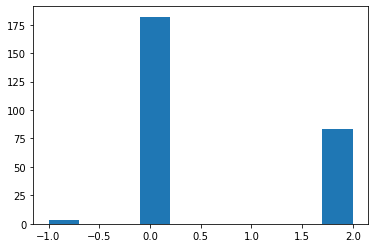

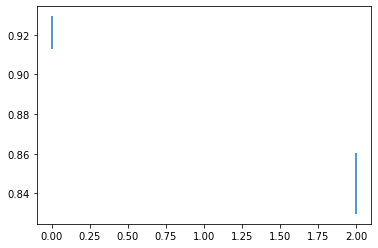

In [25]:
cols = [col for col in df if col.startswith('Rsq')]
#cols =  cols[:3]
best_fn= np.argmax(df.loc[:,cols[:3]].values, axis = 1) # logistic, sinusoidal, gaussian
#best_fn[other_fn_nodes] = 3
maxvals = np.max(df.loc[:,cols[:3]].values, axis = 1)
#maxvals[other_fn_nodes] = df.loc[other_fn_nodes,cols[3]].values
best_fn[maxvals<r2_thr] = -1
plt.hist(best_fn)

unique,times = np.unique(best_fn, return_counts=True)
print(cols, '\n',times.T)
plt.figure(2)
#nfunctions = 4
mean_i = np.empty((nfunctions,))
sem_i = np.empty((nfunctions,))
for i in range(nfunctions):
    inds = np.where(best_fn==i)[0]
    mean_i[i] = np.nanmean(maxvals[inds])
    sem_i[i] = stats.sem(maxvals[inds],nan_policy='omit')
    print('Mean, fn '+str(i)+' = '+ str(np.round(mean_i[i],2)))
    

plt.errorbar(range(nfunctions),mean_i,sem_i)
    
print('Unfit nodes:', np.where(best_fn==-1)[0])
print('\nMin rsq:',min(maxvals[best_fn!=1]))

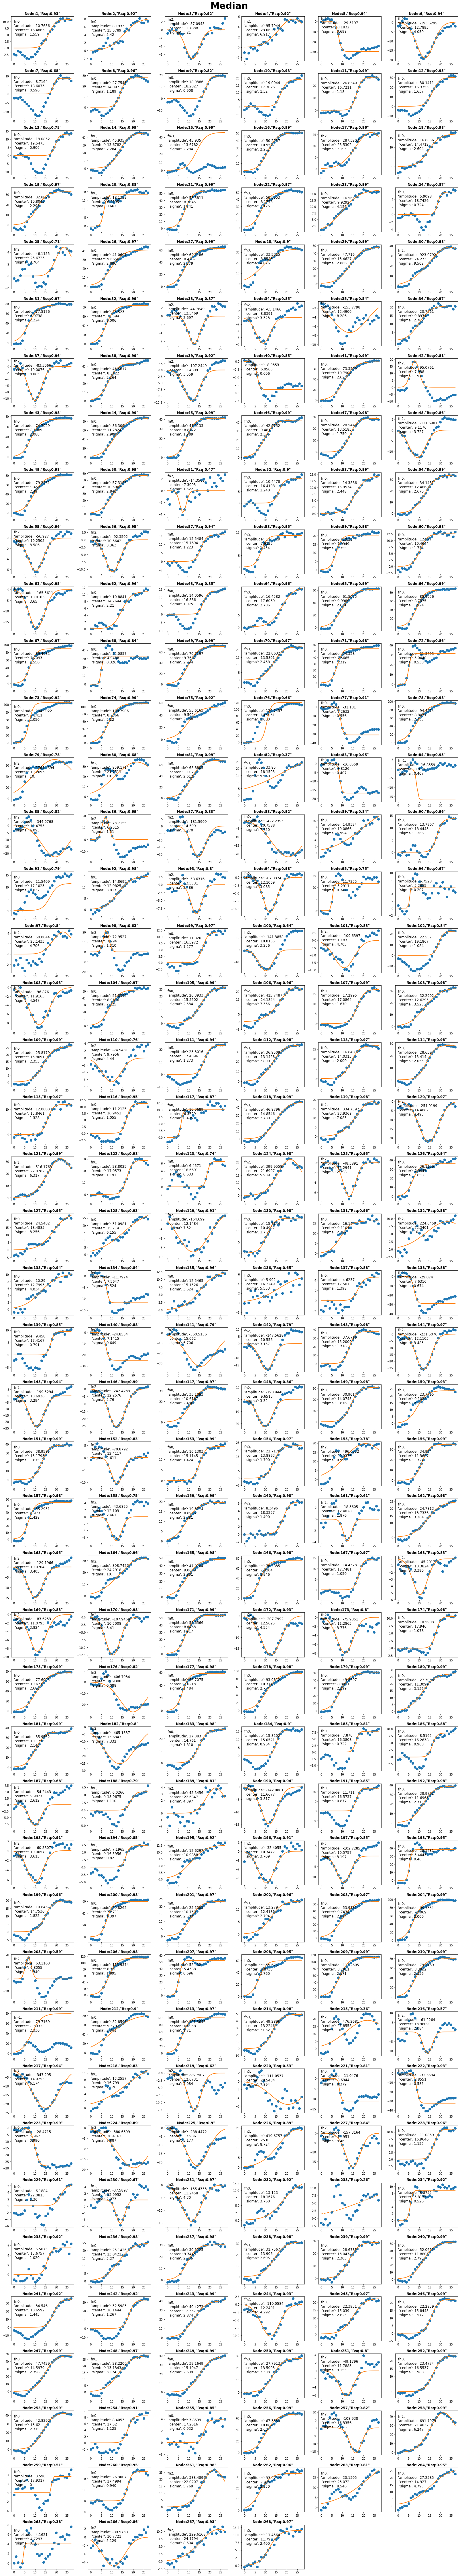

In [28]:
#Plotting medians instead of means

#aic = df_modelfits.iloc[:,[7,8,10,12]].values 
plot_fig=0
ncols = 6
nrows= int(np.ceil(268/ncols))
#fig, axes = plt.subplots(67,4, figsize=(15,150))
xwidth = 22.5
yheight = 125# .75*nrows*xwidth/ncols
fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize = (xwidth,yheight))
fig.set_figwidth(xwidth)
fig.set_figheight(yheight)
fig.suptitle('Median', y=.998,fontsize = 32, fontweight = 'bold')
#r2_thr = .7
for n in range(268):
    
    r = int(np.floor(n/ncols))
    c = int(np.floor(n%ncols))
    
    y = median_tc[n,3:-1]
    if best_fn[n] == 0:
        params_best,param_keys,r2,aic, result = logfit_fn(y)
    elif best_fn[n] == 1:
        params_best,param_keys,r2,aic, result = sinefit_fn(y) 
    elif best_fn[n] == 2:
        params_best,param_keys,r2,aic, result = gaussianfit_fn(y) 
    elif best_fn[n] == 3:
        params_best,param_keys,r2,aic, result = stepsine_fn(y) 
    
    ax[r,c].plot(y,linestyle = 'None', marker = 'o', markersize = 8)
    ax[r,c].set_title(f'Node:{n+1},"Rsq:{np.round(r2,2)}"', fontweight = 'bold')
    if r2> r2_thr:
        ax[r,c].plot(result.best_fit, linewidth = 2)
    elif r2<= r2_thr:
        ax[r,c].plot(result.best_fit, linewidth = 2, ls = 'dashed')
    
    #printing parameters
    bestval = result.best_values
    if 'form' in bestval.keys():
        del bestval["form"]
    for key, value in bestval.items():
        bestval[key] = np.round(bestval[key],4)
    bestval_str = str(bestval)
    bestval_str= bestval_str[1:-2]
    bestval_str = bestval_str.split(',')
    bestval_str = "\n".join(bestval_str)
    #print(bestval_str)
    (y1,y2) = ax[r,c].get_ylim()
    if r2 > r2_thr:
        ax[r,c].text(0,.9*y2,f'fn{best_fn[n]}, \n{bestval_str}',va = 'top', size = 12, color = 'black')

ax[r,c+1].axis('off')
ax[r,c+2].axis('off')

    
plt.tight_layout()

### # At this stage, it maybe useful to manually go through each node in the plot above to decided good and bad fits

In [ ]:
'''other_fn_nodes = np.array([1,7,9,13,24,42,51,52,63,86,95,97,98,100,102,139,142,
                           158,167,184,185,186,187, 188, 191,194,205,219,225,227,
                           241,242,254,255])'''
other_fn_nodes = np.array([7,9,13,24,42,63,86,98,100,102,139,142,
                           158,167,186,187, 188, 191,194,205,219,225,
                           254,255])


other_fn_nodes -= 1 #change from 1 to 268
other_fn_nodes
print(f'{len(other_fn_nodes)} nodes.')

df = pd.DataFrame({'Rsq':np.array(r2_all),'Fn':best_fn})
df.to_csv('BestFitFnRsq.csv', index=False)  

This is how I got the best curves:
(1) find the best of 3 curves: sigmoid, sine, gaussian
(2) examine manually and mark the ones that can be improved - these turned out to be a delayed sinusoidal function
(3) defined a delayed sine function and the curve-fit function for it
(4) fit manually selected nodes with the delayed sine function
(5) see if fits improve - if not, stick to original fucntions
(6) plot mean and median timecourses for each nodes above

Next: What about when yes vs. no responses have different best fit functions?

- Most nodes fit well and the functions make sense. But some sine functions are still missed

### Curve-fitting for yes and no responses

In [29]:
median_tc_yes.shape

(268, 32)

In [30]:
#del df
# getting rsq values for each curve and movie (to be replaced in the future by getting an average timecourse
# across movies and then fitting it)

#Yes

params_array_yes = function_fits(median_tc_yes[:,3:-1])
df_yes = pd.DataFrame(params_array_yes,columns = colnames) 

#No
params_array_no = function_fits(median_tc_no[:,3:-1])
df_no = pd.DataFrame(params_array_no,columns = colnames) 
df_no.head()

fn: 0
fn: 1
fn: 2
fn: 3
fn: 0
fn: 1
fn: 2
fn: 3


f0param1   f0param2  f0param3  f1param1  f1param2  f1param3    f2param1  \
0  10.672997  14.139507  1.626448  0.011966  2.997894 -5.373524  175.754868   
1   7.023748  18.861802  7.206711  0.747773  2.807474 -2.754682  116.945127   
2   4.043629  21.222567  1.520960  0.955207  1.557297  6.117105  -27.164828   
3   6.712323  10.854552  2.179425  1.000000  1.931419 -2.980856  144.766587   
4 -23.181018   8.451577  0.609944  0.982267  0.607563  1.040829 -492.267531   

    f2param2  f2param3  f3param1  ...  f3param4  Rsq_Logistic  Rsq_Sinusoidal  \
0  22.293662  5.872949       3.0  ...  3.017430      0.947506       -0.000310   
1  24.999986  9.999999       3.0  ...  2.070337      0.725190        0.085186   
2  11.272482  2.211737       3.0  ...  2.747785      0.546806        0.225378   
3  21.303795  7.918242       3.0  ...  0.094002      0.929208        0.068176   
4  17.854815  7.093630       3.0  ...  2.961814      0.941660        0.083783   

   Rsq_Gaussian  Rsq_Stepsin  AIC_Logistic  AIC_Sinusoidal  AIC_Gaussian  \
0      0.938022     0.609937     23.196511      115.309187     27.207397   
1      0.698116     0.056709      6.241550       69.044852      8.807258   
2      0.647512     0.863809     43.669627       52.047252     39.289873   
3      0.908765    -0.025542     -7.316297       94.168985      0.064764   
4      0.796412     0.877951     63.615681      170.301537     98.152529   

   AIC_Stepsin  Nodes  
0   104.698258    0.0  
1    70.600012    1.0  
2     5.761340    2.0  
3    96.670057    3.0  
4    85.340311    4.0  

[5 rows x 22 columns]

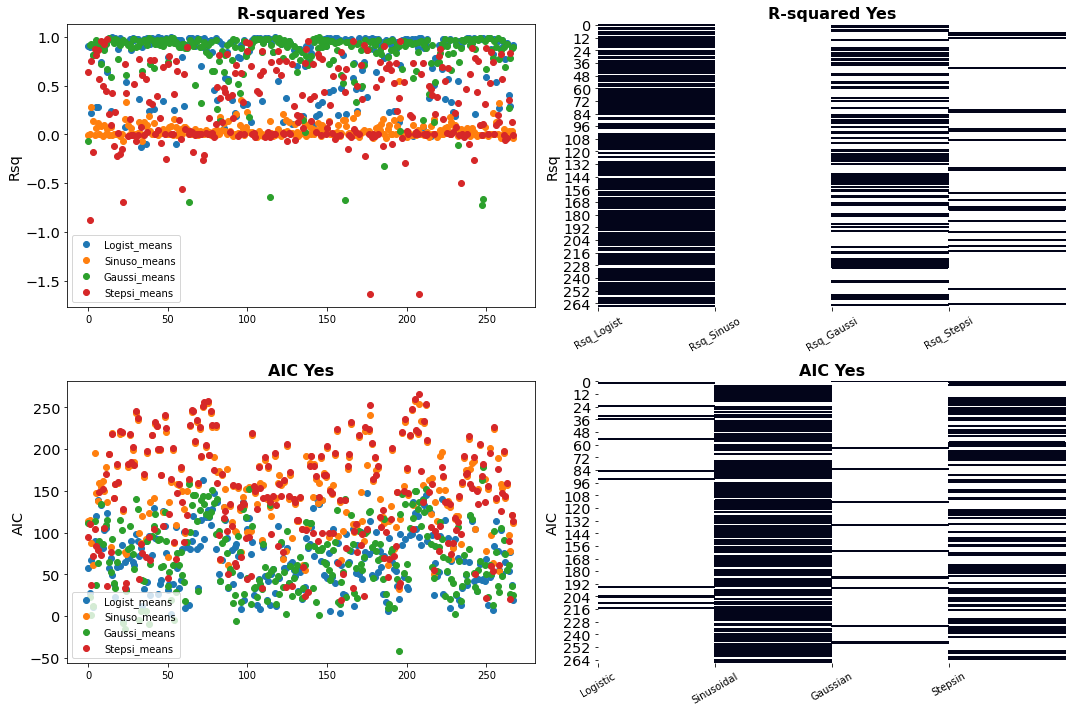

In [32]:
# plotting functionwise fit metrics (rsq and aic)

plt.figure(1,figsize = (15,10))

plt.subplot(2,2,1)
cols = [col for col in df_yes if col.startswith('Rsq')]
plt.title('R-squared Yes',fontsize = 16, fontweight = 'bold')
for colname in cols:
    plt.plot(range(268),df_yes[colname].values,label = colname[4:10] + '_means',
            marker = 'o', linestyle = 'None')
plt.legend()

plt.ylabel ("Rsq", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
lbls = [i[4:] for i in cols]

plt.subplot(2,2,2)
plt.title('R-squared Yes',fontsize = 16, fontweight = 'bold')
mat = df_yes[cols].values
#print(mat)
mat1 = np.empty_like(mat)
mat1[:] = np.nan
for row in range(mat.shape[0]):
    col = np.argmax(mat[row,:])
    mat1[row,col] = 1
sns.heatmap(mat1,cbar = False)
plt.ylabel ("Rsq", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
lbls = [i[:10] for i in cols]
plt.xticks(range(len(cols)), lbls, rotation = 30)
lbls = [i[4:] for i in cols]

plt.subplot(2,2,3)
plt.title('AIC Yes', fontsize = 16, fontweight = 'bold')
cols = [col for col in df_yes if col.startswith('AIC')]
for colname in cols:
    plt.plot(range(268),df_yes[colname].values,label = colname[4:10] + '_means',
             marker = 'o', linestyle = 'None')

plt.ylabel ("AIC", fontsize = 'x-large')
plt.yticks(fontsize='x-large')

plt.legend(loc = 'lower left')


plt.subplot(2,2,4)
cols = [col for col in df_no if col.startswith('Rsq')]
plt.title('AIC Yes',fontsize = 16, fontweight = 'bold')
mat = df_yes[cols].values
mat1 = np.empty_like(mat)
mat1[:] = np.nan
for row in range(mat.shape[0]):
    col = np.argmin(mat[row,:])
    mat1[row,col] = 1
sns.heatmap(mat1, cbar = False)#sns.heatmap(df_modelfits[cols].values,)
plt.ylabel ("AIC", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(range(len(cols)), lbls, rotation = 30)

plt.tight_layout()

In [35]:
df_yes[colname].values.shape

(268,)

In [33]:
cols = [col for col in df_yes if col.startswith('Rsq')]
mat = np.empt((268,4))
for ind, colname in enumerate(cols):
    mat[:,ind] = df_yes[colname].values
    
    ### finish the code to plot best fits with eah node, and then manually label them as good or bad fits.

['Rsq_Logistic', 'Rsq_Sinusoidal', 'Rsq_Gaussian', 'Rsq_Stepsin']

In [ ]:
ncols = 6
nrows= int(np.ceil(268/ncols))
#fig, axes = plt.subplots(67,4, figsize=(15,150))
xwidth = 22.5
yheight = 125# .75*nrows*xwidth/ncols
fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize = (xwidth,yheight))
fig.set_figwidth(xwidth)
fig.set_figheight(yheight)
fig.suptitle('Best individual function based on median curves', y=.998,fontsize = 32, fontweight = 'bold')

not_fit = np.zeros((268,2))
#r2_thr = .6
for n in range(268):
    
    r = int(np.floor(n/ncols))
    c = int(np.floor(n%ncols))
            
    for resp in ['Yes','No']:
        if resp =='Yes':
            y = median_tc_yes[n,:]
            bf = best_fn_yes[n]
            col = 'r'
        elif resp =='No':
            y = median_tc_no[n,:]
            bf = best_fn_no[n]
            col ='b'
        #bf = best_fn[n]
        y=y[3:-1]
        if bf == 0:
            params_best,param_keys,r2,aic, result = logfit_fn(y)
        elif bf == 1:
            params_best,param_keys,r2,aic, result = sinefit_fn(y) 
        elif bf == 2:
            params_best,param_keys,r2,aic, result = gaussianfit_fn(y) 
        elif bf == 3:
            params_best,param_keys,r2,aic, result = stepsine_fn(y) 
    
        ax[r,c].plot(y,linestyle = 'None', marker = 'o', alpha = .5, markersize = 8, color = col)
        if (r2> r2_thr) and (bf!= -1):
            ax[r,c].plot(result.best_fit, color = col, linewidth = 2, label = f'{resp},rsq:{np.round(r2,2)}')
        else:
            ax[r,c].plot(result.best_fit, color = col, linewidth = 2, linestyle='dashed')
            if resp == 'Yes':
                not_fit[n,0] = 1
            elif resp == 'No':
                not_fit[n,1] = 1
    
    ax[r,c].set_title(f'Node:{n+1}', fontweight = 'bold')

ax[r,c+1].axis('off')
ax[r,c+2].axis('off')


    
plt.tight_layout()

In [25]:
manual_label = 1 # change to 1 AFTER manual labelling to test fit after.


In [26]:
if manual_label:
    xls = pd.ExcelFile('Mean_data_best_fits.xlsx')
    df_yes_vs_no = pd.read_excel(xls, 'Yes vs. No')
    df_yes_vs_no.head()

In [27]:
if manual_label:
    df_yes_vs_no["BestfitYes_manual"].values

In [28]:
if manual_label:
    df_yes_vs_no = df_yes_vs_no.iloc[:268,:7]
    df_yes_vs_no = df_yes_vs_no.replace(['sigmoid'],0)
    df_yes_vs_no = df_yes_vs_no.replace(['sinusoidal'],1)
    df_yes_vs_no = df_yes_vs_no.replace(['gaussian'],2)
    df_yes_vs_no = df_yes_vs_no.replace(['delayed sine'],3)
    df_yes_vs_no = df_yes_vs_no.replace(['other fn2'],4) # to be defined later. Ignore for now

    yes_vec = df_yes_vs_no["BestfitYes_manual"].values
    yes_ind = np.where(yes_vec != 4)[0] # yes vectors following one of the four known fns
    
    no_vec = df_yes_vs_no["BestfitNo_manual"].values
    no_ind = np.where(no_vec != 4)[0]


    df_yes_vs_no
len(yes_ind)

268

In [29]:
verify = 1 # 1= after manual verification of the manual fits, 0 = before

if verify:
    yes_dont_change_ind = np.array([8,10,12,51,82,87,90,91,93,125,152,184,186,193,205,211,215,230,233,266])
    # don't change these curves
    yes_dont_change_ind  -= 1
    yes_ind = np.delete(yes_ind,yes_dont_change_ind)

    no_dont_change_ind  = np.array([3,10,13,15,52,90,93,120,123,125,158,176,184,189,205,211,215,216,220,221,227,233,241])
    no_dont_change_ind  -= 1 
    no_ind = np.delete(no_ind,no_dont_change_ind)
len(yes_ind)

248

yes: [0 1 2] [178   1  89]
Mean, fn 0 = 0.91
Mean, fn 1 = 0.18
Mean, fn 2 = 0.86
Mean, fn 3 = nan
Unfit nodes: []

no: [0 1 2] [190   1  77]
Mean, fn 0 = 0.89
Mean, fn 1 = 0.74
Mean, fn 2 = 0.84
Mean, fn 3 = nan
Unfit nodes: []


/Users/f0053cz/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


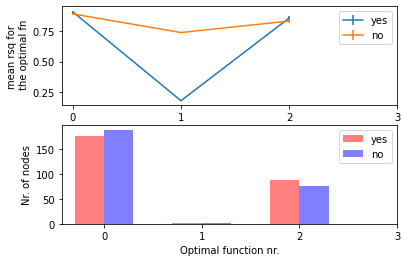

In [27]:
cols = [col for col in df_yes if col.startswith('Rsq')]
#cols = cols[:3]
best_fn_yes = np.argmax(df_yes.loc[:,cols[:3]].values, axis = 1) # max of logistic, sinusoidal, gaussian fns.
maxvals_yes = np.max(df_yes.loc[:,cols[:3]].values, axis = 1)

manual_label=0




if manual_label:
    #best_fn_yes[yes_vec==3] = 3
    #maxvals_yes[yes_vec==3] = df_yes.loc[yes_vec==3,cols[3]].values
    best_fn_yes[yes_ind] = yes_vec[yes_ind]
    maxvals_yes[yes_ind] = df_yes.loc[yes_ind,cols[3]].values

#best_fn_yes[maxvals_yes<r2_thr] = -1

unique_yes,times_yes = np.unique(best_fn_yes, return_counts=True)
print('yes:', unique_yes,times_yes)

plt.figure(1)
mean_i = np.empty((nfunctions,))
sem_i = np.empty((nfunctions,))
for i in range(nfunctions):
    inds = np.where(best_fn_yes==i)[0]
    mean_i[i] = np.mean(maxvals_yes[inds])
    sem_i[i] = stats.sem(maxvals_yes[inds])
    print('Mean, fn '+str(i)+' = '+ str(np.round(mean_i[i],2)))

plt.subplot(2,1,1)
plt.errorbar(range(nfunctions),mean_i,sem_i,label = 'yes')
    
print('Unfit nodes:', np.where(best_fn_yes==-1)[0])


best_fn_no  = np.argmax(df_no.loc[:,cols[:3]].values, axis = 1) # logistic, sin, gaussian
maxvals_no = np.max(df_no.loc[:,cols[:3]].values, axis = 1)
if manual_label:
    #best_fn_no[no_vec==3] = 3
    #maxvals_no[no_vec==3] = df_no.loc[no_vec==3,cols[3]].values
    best_fn_no[no_ind] = no_vec[no_ind]
    maxvals_no[no_ind] = df_no.loc[no_ind,cols[3]].values
#best_fn_no[maxvals_no<r2_thr] = -1

unique_no,times_no = np.unique(best_fn_no, return_counts=True)

print('\nno:', unique_no,times_no)
mean_i = np.empty((nfunctions,))
sem_i = np.empty((nfunctions,))
for i in range(nfunctions):
    inds = np.where(best_fn_yes==i)[0]
    mean_i[i] = np.mean(maxvals_no[inds])
    sem_i[i] = stats.sem(maxvals_no[inds])
    print('Mean, fn '+str(i)+' = '+ str(np.round(mean_i[i],2)))

plt.errorbar(range(nfunctions),mean_i,sem_i, label = 'no')
plt.xticks(range(4))
plt.xlabel ('Optimal function nr.')
plt.ylabel('mean rsq for\n the optimal fn')

print('Unfit nodes:', np.where(best_fn_no==-1)[0])
plt.legend()

plt.subplot(2,1,2)

plt.bar(unique_yes,times_yes, align='edge', width = -.3,alpha = .5, label = 'yes', color = 'r')
plt.bar(unique_no,times_no, align = 'edge', width = .3, alpha = .5, label = 'no', color = 'b')
plt.xticks(range(4))
plt.xlabel ('Optimal function nr.')
plt.ylabel('Nr. of nodes')

plt.legend()



In [31]:
# RUN THIS CELL
#load behavioral responses, a subject*movies matrix of responses (1=yes,0=no,9=unsure, -1=no response)
responses = np.load(os.path.join(data_file_loc,'responses_slopereg.npy'))
responses.shape

(1049, 10)

In [32]:
inds = np.where(best_fn_yes!=best_fn_no)[0]
for slno,i in enumerate(inds):
    print(slno,'. node:',i,' yes:',best_fn_yes[i],',no:', best_fn_no[i])

0 . node: 0  yes: 3 ,no: 0
1 . node: 2  yes: 2 ,no: 1
2 . node: 6  yes: 3 ,no: 0
3 . node: 8  yes: 3 ,no: 0
4 . node: 10  yes: 3 ,no: 0
5 . node: 12  yes: 3 ,no: 0
6 . node: 14  yes: 3 ,no: 0
7 . node: 23  yes: 2 ,no: 0
8 . node: 24  yes: 2 ,no: 0
9 . node: 32  yes: 2 ,no: 0
10 . node: 33  yes: 2 ,no: 3
11 . node: 34  yes: 0 ,no: 2
12 . node: 38  yes: 2 ,no: 3
13 . node: 41  yes: 3 ,no: 2
14 . node: 50  yes: 0 ,no: 1
15 . node: 54  yes: 2 ,no: 3
16 . node: 63  yes: 0 ,no: 1
17 . node: 81  yes: 1 ,no: 0
18 . node: 86  yes: 2 ,no: 3
19 . node: 90  yes: 2 ,no: 0
20 . node: 92  yes: 2 ,no: 0
21 . node: 93  yes: 2 ,no: 3
22 . node: 95  yes: 0 ,no: 2
23 . node: 96  yes: 0 ,no: 3
24 . node: 121  yes: 3 ,no: 0
25 . node: 122  yes: 3 ,no: 2
26 . node: 151  yes: 2 ,no: 1
27 . node: 157  yes: 2 ,no: 0
28 . node: 159  yes: 3 ,no: 0
29 . node: 160  yes: 3 ,no: 0
30 . node: 162  yes: 2 ,no: 3
31 . node: 166  yes: 3 ,no: 0
32 . node: 167  yes: 0 ,no: 3
33 . node: 168  yes: 0 ,no: 2
34 . node: 172  ye

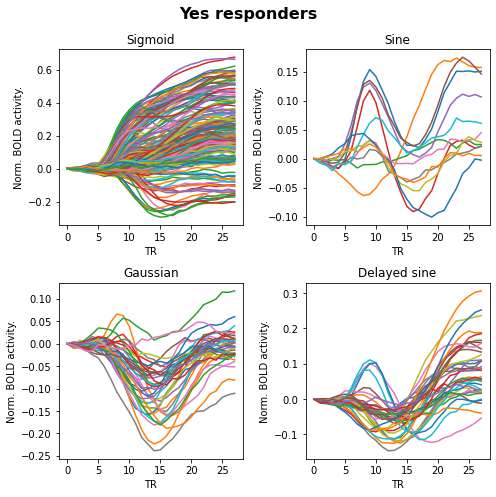

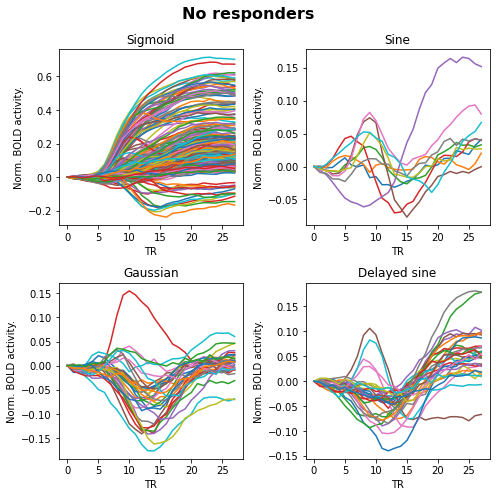

In [37]:
fn_lbl = ['Sigmoid','Sine','Gaussian','Delayed sine']
for i,median_tc in enumerate([median_tc_yes,median_tc_no]):
    if i ==0:
        best_fn = best_fn_yes
        title_lbl =  'Yes responders'
    elif i == 1:
        best_fn = best_fn_no
        title_lbl =  'No responders'
    
    plt.figure(i+1,figsize = (7,7))
    plt.suptitle(title_lbl,fontsize = 16, fontweight = 'bold')
    for fn in range(4):
        plt.subplot(2,2,fn+1)
        plt.title(fn_lbl[fn])
        plt.plot(np.arange(0,28),median_tc[best_fn==fn,:].T)
        plt.xlabel('TR')
        plt.ylabel('Norm. BOLD activity.')
    plt.tight_layout()

In [12]:
r2_thr = .6

In [6]:
import matplotlib
#help(matplotlib.rc)
matplotlib.rc('axes',edgecolor='grey')

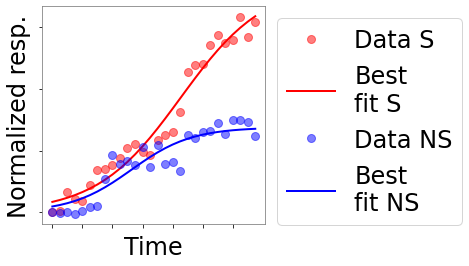

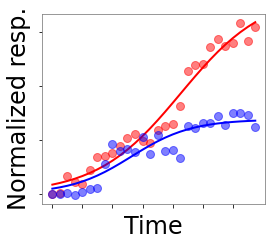

In [39]:
n=1
col = ['r','b']
plt.figure(1,figsize=(4,4))
grp = ['S','NS']
for i,y in enumerate([median_tc_yes[n,:],median_tc_no[n,:]]):
    params_best,param_keys,r2,aic, result = logfit_fn(y)
    plt.plot(y,linestyle = 'None', marker = 'o', alpha = .5, markersize = 8,
             color = col[i],label =f'Data {grp[i]}')
    if (r2> r2_thr) :
        plt.plot(result.best_fit, color = col[i], linewidth = 2, 
                 label=f'Best\nfit {grp[i]}')
    else:
        plt.plot(result.best_fit, color = col[i], linewidth = 2, linestyle='dashed')
        
    plt.xticks(np.arange(0,28,4),[])
    plt.yticks(np.linspace(0,0.08,4),[])
    plt.xlabel('Time',fontsize=24)
    plt.ylabel('Normalized resp.',fontsize=24)
    #plt.title('Node 2',fontsize=24)
plt.legend(fontsize = 24,bbox_to_anchor=(1, 1))



n=1
col = ['r','b']
plt.figure(2,figsize=(4,3.5))
grp = ['yes','no']
for i,y in enumerate([median_tc_yes[n,:],median_tc_no[n,:]]):
    params_best,param_keys,r2,aic, result = logfit_fn(y)
    plt.plot(y,linestyle = 'None', marker = 'o', alpha = .5, markersize = 8, color = col[i],label =f'Data, {grp[i]}')
    if (r2> r2_thr) :
        plt.plot(result.best_fit, color = col[i], linewidth = 2, 
                 label=f'Best fit {grp[i]}')
    else:
        plt.plot(result.best_fit, color = col[i], linewidth = 2, 
                 linestyle='dashed')
        
    plt.xticks(np.arange(0,28,4),[])
    plt.yticks(np.linspace(0,0.08,4),[])
    plt.xlabel('Time',fontsize=24)
    plt.ylabel('Normalized resp.',fontsize=24)
    #plt.title('Node 2',fontsize=24)

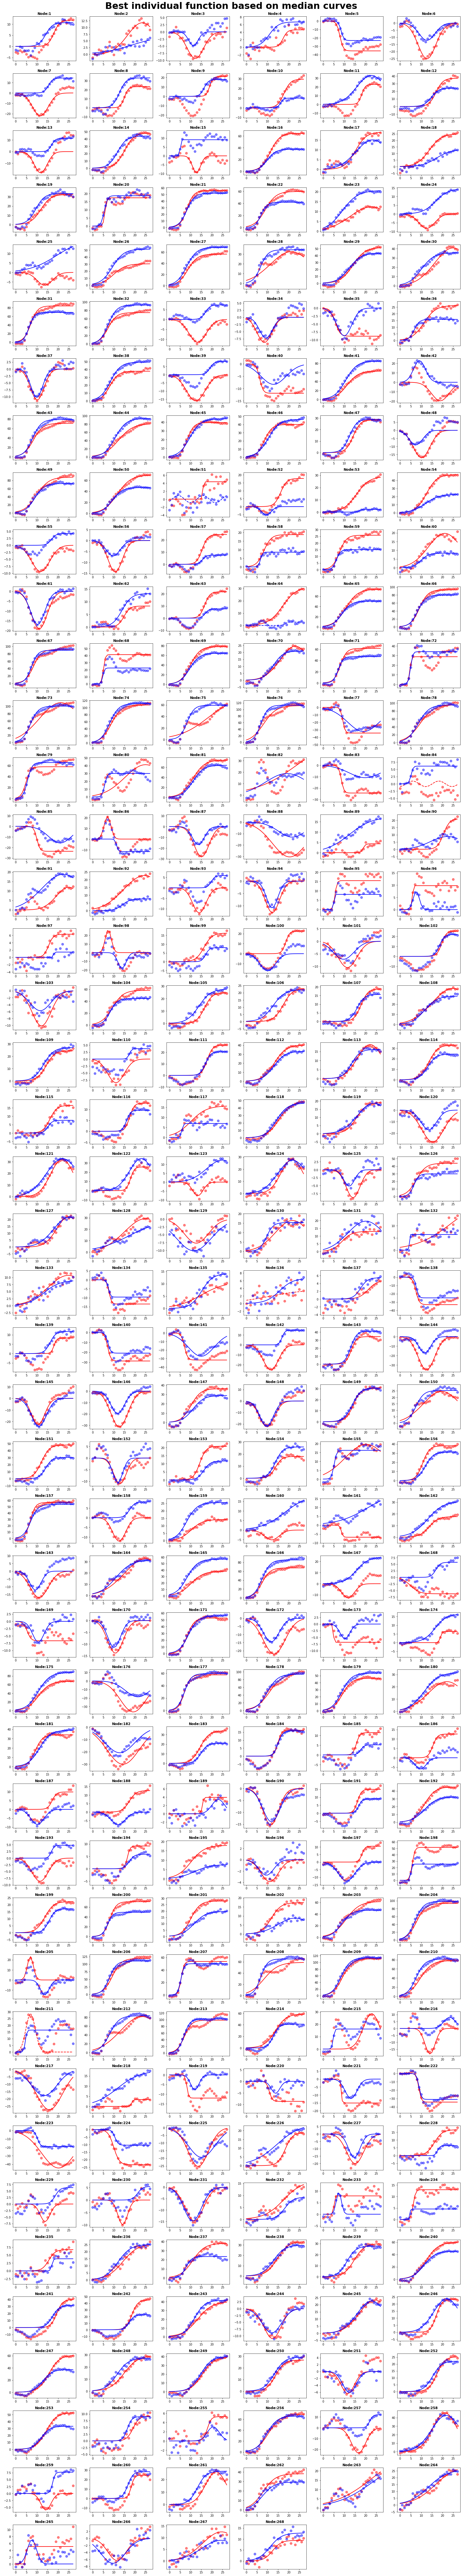

In [29]:
ncols = 6
nrows= int(np.ceil(268/ncols))
#fig, axes = plt.subplots(67,4, figsize=(15,150))
xwidth = 22.5
yheight = 125# .75*nrows*xwidth/ncols
fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize = (xwidth,yheight))
fig.set_figwidth(xwidth)
fig.set_figheight(yheight)
fig.suptitle('Best individual function based on median curves', y=.998,fontsize = 32, fontweight = 'bold')

not_fit = np.zeros((268,2))
#r2_thr = .6
for n in range(268):
    
    r = int(np.floor(n/ncols))
    c = int(np.floor(n%ncols))
            
    for resp in ['Yes','No']:
        if resp =='Yes':
            y = median_tc_yes[n,:]
            bf = best_fn_yes[n]
            col = 'r'
        elif resp =='No':
            y = median_tc_no[n,:]
            bf = best_fn_no[n]
            col ='b'
        #bf = best_fn[n]
        y=y[3:-1]
        if bf == 0:
            params_best,param_keys,r2,aic, result = logfit_fn(y)
        elif bf == 1:
            params_best,param_keys,r2,aic, result = sinefit_fn(y) 
        elif bf == 2:
            params_best,param_keys,r2,aic, result = gaussianfit_fn(y) 
        elif bf == 3:
            params_best,param_keys,r2,aic, result = stepsine_fn(y) 
    
        ax[r,c].plot(y,linestyle = 'None', marker = 'o', alpha = .5, markersize = 8, color = col)
        if (r2> r2_thr) and (bf!= -1):
            ax[r,c].plot(result.best_fit, color = col, linewidth = 2, label = f'{resp},rsq:{np.round(r2,2)}')
        else:
            ax[r,c].plot(result.best_fit, color = col, linewidth = 2, linestyle='dashed')
            if resp == 'Yes':
                not_fit[n,0] = 1
            elif resp == 'No':
                not_fit[n,1] = 1
    
    ax[r,c].set_title(f'Node:{n+1}', fontweight = 'bold')

ax[r,c+1].axis('off')
ax[r,c+2].axis('off')


    
plt.tight_layout()

In [738]:
df_best_fns = pd.DataFrame({'AllSubs':best_fn, 'YesResponders': best_fn_yes, 'NoResponders':best_fn_no})
df_best_fns.head()

df_best_fns.to_csv('Best_functions.csv')

In [4]:
df_best_fns = pd.read_csv('Best_functions.csv')
df_best_fns.head()

Unnamed: 0  AllSubs  YesResponders  NoResponders
0           0        0              3             0
1           1        0              0             0
2           2        2              2             1
3           3        2              0             0
4           4        0              0             0

In [5]:
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

In [53]:
np.unique(df_best_fns["YesResponders"])

array([0, 1, 2, 3])

In [56]:
print(len(np.where(df_best_fns["YesResponders"]!=df_best_fns["NoResponders"])[0]))


59


In [54]:
for i in range(4):
    print(len(np.where(df_best_fns["NoResponders"]==i)[0]))


194
10
33
31


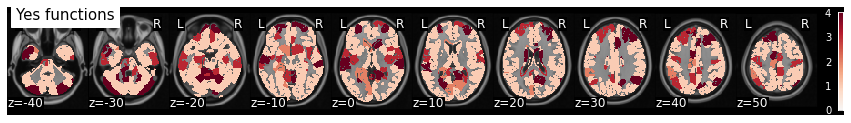

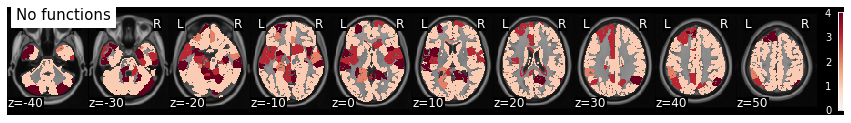

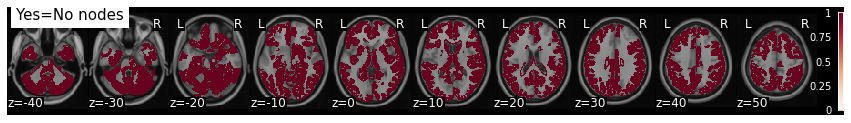

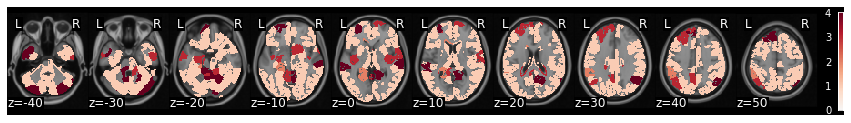

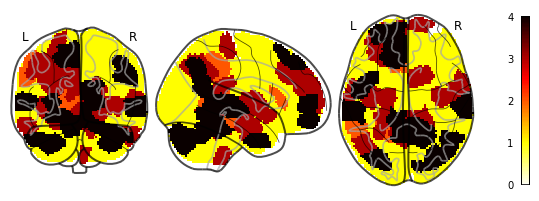

In [9]:
for resp in ["Yes","No"]:
    nodes = df_best_fns[f"{resp}Responders"].values+1
    #nodes[nodes == -1] = np.nan
    img = roi_to_brain(pd.Series(nodes), mask_x)
    img.plot(colorbar=True, title = f"{resp} functions", cmap = 'RdBu_r')

    
nodes = df_best_fns["YesResponders"].values-df_best_fns["NoResponders"].values
#print(nodes)
nodes[nodes == 0] = 1000
nodes[nodes <1000] = 0
nodes[nodes ==1000] = 1
#print(nodes)
img = roi_to_brain(pd.Series(nodes), mask_x)
img.plot(colorbar=True, title = f"Yes=No nodes", cmap = 'RdBu_r')





In [22]:
nodes_str

[nan,
 'Sine',
 nan,
 'Sine',
 'Sine',
 'Delayed sine',
 nan,
 'Sine',
 nan,
 'Sine',
 nan,
 'Sine',
 nan,
 'Sine',
 nan,
 'Sine',
 'Sine',
 'Sine',
 'Sine',
 'Sine',
 'Sine',
 'Sine',
 'Sine',
 nan,
 nan,
 'Sine',
 'Sine',
 'Sine',
 'Sine',
 'Sine',
 'Sine',
 'Sine',
 nan,
 nan,
 nan,
 'Sine',
 'Delayed sine',
 'Sine',
 nan,
 'Sine',
 'Sine',
 nan,
 'Sine',
 'Sine',
 'Sine',
 'Sine',
 'Sine']

In [31]:
mask_x

nltools.data.brain_data.Brain_Data(data=(268, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])

In [29]:
pd.Series(nodes_str)

0          NaN
1      Sigmoid
2          NaN
3      Sigmoid
4      Sigmoid
        ...   
263    Sigmoid
264        NaN
265        NaN
266    Sigmoid
267        NaN
Length: 268, dtype: object

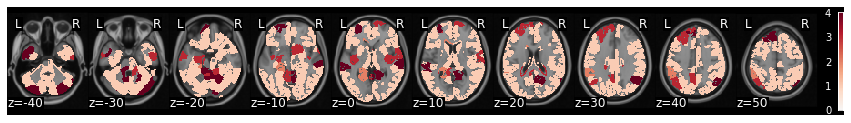

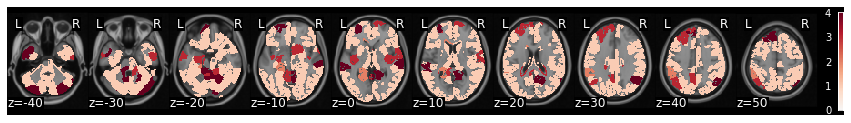

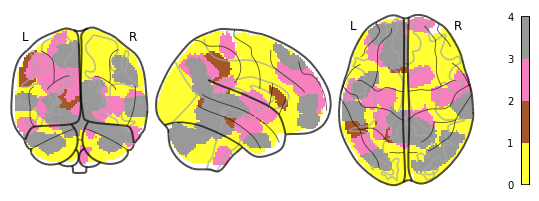

In [33]:
nodes = df_best_fns["YesResponders"].values-df_best_fns["NoResponders"].values
#print(nodes)
nodes[nodes == 0] = 1000
nodes[nodes <1000] = 0
nodes[nodes ==1000] = df_best_fns["YesResponders"].values[nodes ==1000]+1
#print(nodes)
img = roi_to_brain(pd.Series(nodes), mask_x)
img.plot(colorbar=True, cmap = 'RdBu_r')

from nilearn.plotting import plot_glass_brain
'''lbls = ['Sigmoid','Sine','Gaussian','Delayed sine']
nodes_str = []
for i in range(268):
    #print(i)
    if nodes[i]>0:
        nodes_str.append(lbls[nodes[i]-1])
    else:
        nodes_str.append(np.nan)
        
img = roi_to_brain(pd.Series(nodes_str), mask_x)'''
img = roi_to_brain(pd.Series(nodes), mask_x)
img.plot(colorbar=True, cmap = 'RdBu_r')


plot_glass_brain(img.to_nifti(), colorbar = True, plot_abs=False, black_bg = False, cmap = 'Set1')




In [89]:
param_lbls = [['amp','cen','sig'],
          ['amp','freq','ph'],
          ['amp','cen','sig'],['delay','amp','freq','ph']]
param_lbls[0]

['amp', 'cen', 'sig']

In [84]:
rows = np.array([row['Nodes'] for _,row in df_respbased.iterrows() if row['YN_similarity']])
rows = [int(i) for i in rows]
#rows

### Fitting params to mean function

In [79]:
def response_based_parameters(mean_tc, fns_all):
    #print(fns_all)
    params_array = np.empty((268,6))
    params_array[:] = np.nan

    for node in range(268):
        #print(node)
        fn = fns_all[node]
        y = mean_tc[node,:]
        if fn == 0:
            params_best,param_keys,rsq_node,aic,result = logfit_fn(y)

        elif fn == 1:
            params_best,param_keys,rsq_node,aic,result = sinefit_fn(y)

        elif fn == 2:
            params_best,param_keys,rsq_node,aic,result = gaussianfit_fn(y)

        elif fn == 3:
            params_best,param_keys,rsq_node,aic,result = stepsine_fn(y)
        #print(params_best)
        if fn<3:
            cols = np.arange(0,3)
        else:
            cols = np.arange(0,4)
        params_array[node, cols] = params_best
        params_array[node, 4] = rsq_node
        params_array[node, 5] = aic

    return params_array

In [80]:

colnames = ['Nodes','param1_Yes', 'param2_Yes','param3_Yes','param4_Yes', 'Rsq_Yes','AICYes','Fn_yes',
                    'param1_No', 'param2_No','param3_No','param4_No','Rsq_No','AIC_No', 'Fn_no']
    
r2_thr = .6

node_plot = -1 # Enter a value between 1 and 268?(incl.). Will subtract by 1 in the functiom

_, _, _,_,median_tc_yes, median_tc_no = get_mean_timecourses_respbased()

params_array_yes = response_based_parameters(median_tc_yes, df_best_fns["YesResponders"].values)
params_array_no = response_based_parameters(median_tc_no, df_best_fns["NoResponders"].values)

nodes_ind = np.arange(0,268)
nodes_ind = np.reshape(nodes_ind,(268,1))

fnames_yes = np.reshape( df_best_fns["YesResponders"].values,(268,1))
fnames_no = np.reshape( df_best_fns["NoResponders"].values,(268,1))
dat = np.hstack((nodes_ind, params_array_yes,fnames_yes, params_array_no, fnames_no))
#print(dat)

df_respbased = pd.DataFrame(columns = colnames) 
new_row = pd.DataFrame(dat, columns = colnames)
df_respbased = pd.concat([df_respbased, new_row], ignore_index=True)

df_respbased['YN_similarity'] =  df_respbased['Fn_yes'].values == df_respbased['Fn_no'].values
df_respbased.head()

Nodes  param1_Yes  param2_Yes  param3_Yes  param4_Yes   Rsq_Yes  \
0    0.0    3.000000    0.070005    0.999168    3.084543  0.895885   
1    1.0    0.099117   17.084083    5.588884         NaN  0.965153   
2    2.0   -0.635011   13.941141    3.727120         NaN  0.969996   
3    3.0    0.046682   19.336755    1.655992         NaN  0.870723   
4    4.0   -0.238875    9.987710    0.812777         NaN  0.946603   

       AICYes  Fn_yes  param1_No  param2_No  param3_No  param4_No    Rsq_No  \
0 -197.172409     3.0   0.110151  16.249703   2.066100        NaN  0.974621   
1 -289.463691     0.0   0.036645  10.509156   3.995242        NaN  0.853428   
2 -298.968193     2.0   0.019304   1.408197   6.283195        NaN  0.629479   
3 -273.946067     0.0   0.056995  10.270173   2.984073        NaN  0.960446   
4 -197.706681     0.0  -0.150986  10.461099   0.635299        NaN  0.956088   

       AIC_No  Fn_no  YN_similarity  
0 -261.208925    0.0          False  
1 -287.197854    0.0           True  
2 -241.902337    1.0          False  
3 -292.550115    0.0           True  
4 -224.454471    0.0           True

In [ ]:
from multiprocessing import Pool, cpu_count

if _name_ == '_main_':
    pool = Pool(processes=cpu_count())
    #for things you are inputting in things:
        print(things)
        result = pool.map(fun, [thing you are inputting into your function])
        

In [ ]:
sl_result = Parallel(n_jobs=nproc)(delayed(_run_searchlight)(
                ds.select_features(idx), idx, measure, 
                i=i, n=len(ds.fa['sl_map']), **kwargs)
            for i,idx in enumerate(ds.fa['sl_map']))

## Extra code (prob. useful for later)

In [37]:
# load each movie, perform linear regression for each sub and roi for that movie
movie_ind = 3
fileName = os.path.join(data_file_loc,f'timecourse-movie{movie_ind}.npy')
print(fileName)
movieTC = np.load(fileName) # nsubs * nnodes * ntimepts

mean_movieTC = np.mean(movieTC, axis = 0)
mean_movieTC.shape
X = mean_movieTC

/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/timecourse-movie3.npy


## exploring functions

In [ ]:
def logistic_function(x, A, c, s):
    return A*(1 - (1/ (1+np.exp((x-c)/s)) ))

x = np.arange(30)

fig, ax = plt.subplots()
c = 15
s = 1.5
for A in [1, 2, 3]:
    y_fit = logistic_function(x, A, c, s)
    label = f'A = {A}'
    ax.plot(x, y_fit, label = label)
    ax.legend()
ax.set_title("Different amplitudes")

fig, ax = plt.subplots()
A = 1
s = 1.5
for c in [10, 15, 20]:
    y_fit = logistic_function(x, A, c, s)
    label = f'c = {c}'
    ax.plot(x, y_fit, label = label)
    ax.legend()
ax.set_title("Different centers")    

fig, ax = plt.subplots()
A = 1
c = 15
for s in [0.5, 1, 1.5]:
    y_fit = logistic_function(x, A, c, s)
    label = f's = {s}'
    ax.plot(x, y_fit, label = label)
    ax.legend()
ax.set_title("Different sigmas")    

In [ ]:
# sigmoid curve properties of parameters
# can explore the effect of a,b,c,d here

def sigmoid(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

x= np.arange(1,200)
a= 1#range
b=0 #y0
c=.05#variance
d=50#centre
plt.plot(x,sigmoid(x, a, b, c, d), label='a='+str(a))
plt.vlines(d,b,b+a,'k')
a *= 2
plt.plot(x,sigmoid(x, a, b, c, d), label='a='+str(a))
plt.vlines(d,b,b+a,'k')

plt.legend()

In [ ]:
# logistic_function only

X,movieTC = get_training_instances_matrix(movie_ind)
resp_yes = responses_slopereg[:,movie_ind] == 1
meanTimecourse_yes = np.mean(movieTC[resp_yes,:,:],axis = 0) # nodes, timepts

node = 0
yyes = meanTimecourse_yes[node,:]
x = np.arange(0,(len(yyes)))

model = Model(logistic_function)#,nan_policy = 'omit') # solve this error, add hints etc. in model fits
model.set_param_hint('A', min=-4, max = 4)
model.set_param_hint('c', min=2, max = 25)
model.set_param_hint('s', min=1e-10, max = 500)
params = model.make_params(c=np.argmax(np.diff(yyes)), A = max(yyes)-min(yyes), s = 1)

#yfit = model.eval(params, x=x)
result = model.fit(yyes, params, x=x)
r2 = fit_goodness_test(yyes, result)
#yfit =result.best_fit
#plt.plot(x,y)
#plt.plot(x,yfit)

print(r2)
if r2 > .3:
    print('good fit')
    
#result.plot()
#plt.plot(result.residual)
#plt.plot(yyes)

result.plot_fit()
result.plot_residuals()
fit_rep = result.fit_report()

print(fit_rep)

In [ ]:
# linear only

X,movieTC = get_training_instances_matrix(movie_ind)
resp_yes = responses_slopereg[:,movie_ind] == 1
meanTimecourse_yes = np.mean(movieTC[resp_yes,:,:],axis = 0) # nodes, timepts

node = 0
yyes = meanTimecourse_yes[node,:]
x = np.arange(0,(len(yyes)))

form = 'logistic'
del model
model = LinearModel()
model.set_param_hint('intercept', min=-2, max = 2)
params = model.make_params(intercept=yyes[0])

result = model.fit(yyes, params, x=x)
r2 = fit_goodness_test(yyes, result)


print(r2)
if r2 > .3:
    print('good fit')
    
#result.plot()
#plt.plot(result.residual)
#plt.plot(yyes)

result.plot_fit()
result.plot_residuals()
fit_rep = result.fit_report()

print(fit_rep)

In [ ]:
# linear+logistic

X,movieTC = get_training_instances_matrix(movie_ind)
resp_yes = responses_slopereg[:,movie_ind] == 1
meanTimecourse_yes = np.mean(movieTC[resp_yes,:,:],axis = 0) # nodes, timepts

node = 0
yyes = meanTimecourse_yes[node,:]
x = np.arange(0,(len(yyes)))

form = 'logistic'
model = StepModel(form=form) + LinearModel()
model.set_param_hint('intercept', min=-2, max = 2)
model.set_param_hint('center', min=2, max = 28)
params = model.make_params(center=np.argmax(np.diff(yyes)), intercept=yyes[0])

#yfit = model.eval(params, x=x)
result = model.fit(yyes, params, x=x)
r2 = fit_goodness_test(yyes, result)
#yfit =result.best_fit
#plt.plot(x,y)
#plt.plot(x,yfit)

print(r2)
if r2 > .3:
    print('good fit')
    
#result.plot()
#plt.plot(result.residual)
#plt.plot(yyes)

result.plot_fit()
result.plot_residuals()
fit_rep = result.fit_report()

print(fit_rep)

In [ ]:
flname_suffix = 'logistic'


if savefig:
        nrows, ncols = len(titles)+1,3
        xwidth,yheight = 10,10
        fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize = (xwidth,yheight))
        plt.suptitle(vidnames[movie_ind]+',LogFit',fontweight='bold',fontsize=12)

        t,p = np.zeros((3,)),np.zeros((3,))

        #params_array[node,pind,yind] 
        for pind in range(params_array.shape[1]): # params: e.g. A,c,s
            r= pind
            c= 0
            for rind in range(params_array.shape[2]-1): # yes/no/unsure(all)
                param_per_resp = params_array[good_nodes,pind,rind]
                param_per_resp = param_per_resp[~np.isnan(param_per_resp)]

                if rind == 0:
                    ax[r,c].hist(param_per_resp, color = 'red', alpha = .8, label = 'yes nodes')
                elif rind ==1:
                    ax[r,c].hist(param_per_resp, color = 'blue', alpha = .8, label = 'no nodes')
                elif rind ==2 :
                    ax[r,c].hist(param_per_resp, color = 'green', alpha = .8, label = 'unsure nodes')
                ax[r,c].set_title(titles[pind])
                ax[r,c].set_ylabel('Nr. of nodes')
                if r==0:
                    ax[r,c].legend()

            c=1 # middle column, barplots

            #yes_no_nodes = np.where((~np.isnan(params_array[:,i]))&(~np.isnan(params_no[:,i])))[0]

            for node in good_nodes:
                ax[r,c].plot(range(3),params_array[node,pind,:3], color = 'k', alpha = .2)
            ax[r,c].bar(range(3),np.nanmean(params_array[:,pind,:3],axis=0),
                        color = 'grey', label = 'mean value')
            ax[r,c].set_title(titles[pind])
            ax[r,c].set_xticks([0,1,2])
            ax[r,c].set_xticklabels(['Yes','No','Unsure'])
            ax[r,c].set_ylabel('Parameter estimates')

            if r==0:
                ax[r,c].legend()

            c=2
            #print(yes_no_nodes)
            yes_params = params_array[good_nodes,pind,0]
            no_params = params_array[good_nodes,pind,1]
            n,bins,_ = ax[r,c].hist(yes_params-no_params, color = 'grey', alpha = .4)
            ax[r,c].set_title(titles[pind])
            t,p = stats.ttest_1samp(yes_params-no_params,0)
            if p < .05:
                ax[r,c].vlines(np.mean(yes_params-no_params),0,max(n),
                               'g', ls = 'solid',label = 'Mean Yes-No,\np<.05')
            else:
                ax[r,c].vlines(np.mean(yes_params-no_params),0,max(n),
                               'g', ls = 'dashed',label = 'Mean Yes-No,\np>=.05')
            ax[r,c].vlines(0,0,max(n),'k', ls = 'dotted', label = 'Yes=No')
            if r== 0:
                ax[r,c].legend(loc = 'upper left')

            #ax[r,c].set_xlim(-1.1*max(np.abs(bins)),1.1*max(np.abs(bins)))
            ax[r,c].set_xlabel('Yes-No')
            ax[r,c].set_ylabel('#nodes')
            plt.axis('square')


        for n in range(268):
            ax[params_array.shape[1],0].plot(range(meanTimecourse_yes.shape[1]), meanTimecourse_yes[n,:], color = 'r')#, label = 'Yes')
            ax[params_array.shape[1],0].plot(range(meanTimecourse_no.shape[1]), meanTimecourse_no[n,:], color = 'b')#, label = 'No')

        ax[params_array.shape[1],0].set_title('Yes and No timecourses for nodes in current cluster ')
        ax[params_array.shape[1],0].set_ylabel('Node timecourses')
        ax[params_array.shape[1],0].set_xlabel('Image Nr.')

        tscore,pval = np.zeros((meanTimecourse_yes.shape[1],)),np.zeros((meanTimecourse_yes.shape[1],))
        for i in np.arange(1,meanTimecourse_yes.shape[1]):
            tscore[i], pval[i] = stats.ttest_ind(meanTimecourse_yes[:,i],meanTimecourse_no[:,i])
        #print(len(range(meanTimecourse_yes.shape[1]))
        plt.subplot(params_array.shape[1]+1,3,params_array.shape[1]*3-1)
        plt.plot(range(meanTimecourse_yes.shape[1]), tscore, color = 'k', marker = 'o')
        plt.ylabel('T-score yes-no')
        plt.xlabel('Image Nr.')

        ax[params_array.shape[1],2].axis(False)

        plt.tight_layout()

        plt.savefig(os.path.join(data_file_loc,'figures',
                                 f'{flname_suffix}_paramEsts_{movie_ind}{str.upper(vidnames[movie_ind][:4])}.png'))  

        #if movie_ind <9:
        plt.close()



## Extra code

### clustering analyses

In [ ]:
# RUN ONLY IF NEEDED!
# Make clusters --> useful to get representative nodes from different clusters to test fit

from sklearn.cluster import KMeans

def cluster_node_timecourses(X,nclusters,print_results):
    kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(X)
    if print_results:
        print('\nlabels:' + str(kmeans.labels_) + ', length:' + str(len(kmeans.labels_)))
        for i in range(nclusters):
            print('\ncluster',i,'=',len(np.where(kmeans.labels_==i)[0]))
    return kmeans.labels_

def plot_timecourses(labels,mean_tc):
    
    unique_clusters = np.unique(labels)
    nclusters = len(unique_clusters)
    
    #plt.figure(1, figsize = (5*nclusters,5))
    plt.figure(1, figsize = (5*nclusters,10))
    
    if nclusters <= 4:
        nrows = 1
    else:
        nrows = np.ceil(nclusters/3)
        
    ncols = 3
    nodes_cluster= []
    nodes_cluster_cum= []
    
    for c in unique_clusters:
        
        plt.subplot(2,nclusters,c+1)
        nodes = np.where(labels==c)[0]
        ind = -1

        for n in nodes:
            ind += 1
            row = int(np.floor(ind/ncols))
            col = int(np.floor(ind%ncols))
            mat = movieTC[:,n,:]#sub*timepts
            plt.errorbar(range(mat.shape[1]),np.mean(mat, axis = 0),stats.sem(mat, axis = 0), label = "Node" + str(n+1))
        plt.title('cluster '+str(c) +', ' + str(ind) + 'nodes')
        print(str(ind)+'nodes')
        nodes_cluster.append(ind)
        nodes_cluster_cum.append(np.sum(nodes_cluster))
    plt.tight_layout()
    
    
    
    fileName = os.path.join(data_file_loc,'betapermovie_slopereg.npy')
    beta_slopes = np.load(fileName) # (1049, 10, 268)
    beta_movie = np.mean(beta_slopes[:,movie_ind,:],axis = 0) # averaged across subs
    
    #plt.figure(2,figsize =(4,4))
    plt.subplot(2,2,3)
        
    cluster_means = [np.mean(beta_movie[np.where(labels==i)]) for i in range(nclusters)]
    plt.bar(np.arange(0,nclusters),cluster_means, color = 'grey')
    plt.plot(labels,beta_movie,marker = '.', ls = 'none')
    cluster_lbls = ['cluster'+str(i) for i in range(nclusters)]
    plt.xticks(range(nclusters),cluster_lbls)
    plt.ylabel('Mean reg coefft(avged. \nacross subs)')
    plt.title('Slope regressor coeffts. per cluster', fontsize = 12)
    
    
    #plt.figure(3,figsize = (5,5))
    plt.subplot(2,2,4)
        
    nodes = list(range(268))
    nodes_sorted = [x for _,x in sorted(zip(labels,nodes))]
    nt = 28
    meanTimecourse = np.mean(movieTC[:,:,:nt],axis = 0) # nodes, timepts
    mat0 = np.zeros((len(nodes),len(nodes)))
    mat = np.zeros((len(nodes),len(nodes)))
    for i1,n1 in enumerate(nodes_sorted): #range(movieTC.shape[1]):
        for i2,n2 in enumerate(nodes_sorted):
            mat[i1,i2],p = stats.pearsonr(meanTimecourse[n1,:31],meanTimecourse[n2,:31])
            #mat0[i1,i2],p = stats.spearmanr(meanTimecourse[n1,:31],meanTimecourse[n2,:31])
    sns.heatmap(mat, cmap = 'RdBu_r', center =0, alpha =.3,square = True)
    #sns.heatmap(mat, alpha =0.3)
    plt.hlines(nodes_cluster_cum,0,268, color = 'k', ls = 'solid')
    plt.vlines(nodes_cluster_cum,0,268, color = 'k', ls = 'solid')
    plt.xlabel('nodes_sorted')
    plt.ylabel('nodes_sorted')
    plt.title('Pearson correlation')
    
    plt.tight_layout()

_, mean_tc = get_mean_timecourses() # nodes*timepts
nclusters = 3 # CHANGE THIS TO THE NUMBER OF DESIRED CLUSTERS
labels = cluster_node_timecourses(mean_tc,nclusters,0)
plot_timecourses(labels, mean_tc)


unique_lbls = np.unique(labels)
print('unique labels:',unique_lbls)
lbl = 0
print(f'Nodes in cluster {lbl} : {np.where(labels == lbl)[0]}')

lbl = 1
print(f'Nodes in cluster {lbl} : {np.where(labels == lbl)[0]}')

In [7]:
# RUN THIS CELL
from lmfit.models import StepModel, LinearModel, SineModel
from lmfit import Model

In [8]:

def fit_goodness_test(y,result):
    # function returns R-squared value  (defined as 1 - ratio  of residual to 
    # total variance's sums of squares) 
    # for a given timecourse "y" and fit result "result"
    
    yfit = result.best_fit
    res = y-yfit
    ss_res = np.sum((res - np.mean(res))** 2)# or ss_res = res.var()
    ss_tot = np.sum((y   - np.mean(y))  ** 2)# or ss_tot = y.var()
    
    r2 = 1 - (ss_res / ss_tot)
    #print('r2: ', r2)
    
    return r2

#### Each function

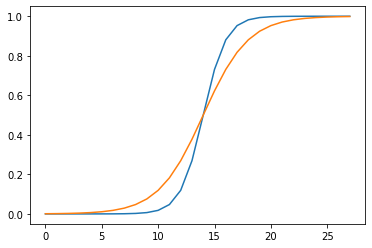

In [10]:
def logistic_function(x, A, c, s):
        return A*(1 - (1/ (1+np.exp((x-c)/s)) ))
    
x = np.arange(0,28)
plt.plot(x,logistic_function(x,1,14,1))
plt.plot(x,logistic_function(x,1,14,2))

In [11]:
def sinefit(y,r2_thr,plot_fig):
    # computes the best fit using a sinusoidal function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    model = SineModel() # set function here
    model.set_param_hint('amplitude', min = 5e-3,max = 1) # set param range here
    model.set_param_hint('frequency', min = .5, max = 2)
    
    params = model.make_params(amplitude = .5, frequency = 2,
                               shift = np.pi ) # set initial param values here
    #y = y[5:]
    #print('y=',y,'\namp init=',max(y, key=abs))
    result = model.fit(y, params, x=np.linspace(0,2*np.pi,len(y)))
    param_keys = list(result.best_values.keys()) # E.g. A,freq,ph
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    if plot_fig:
        result.plot()
        plt.suptitle('Sinusoidal, Rsq='+str(np.round(r2,2)),fontweight = 'bold')
    #print(result.best_values)
    #if r2 > r2_thr:
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname]
    #else:
    #    params_best[:] = np.nan
        
    return params_best,param_keys, r2, result.aic,result

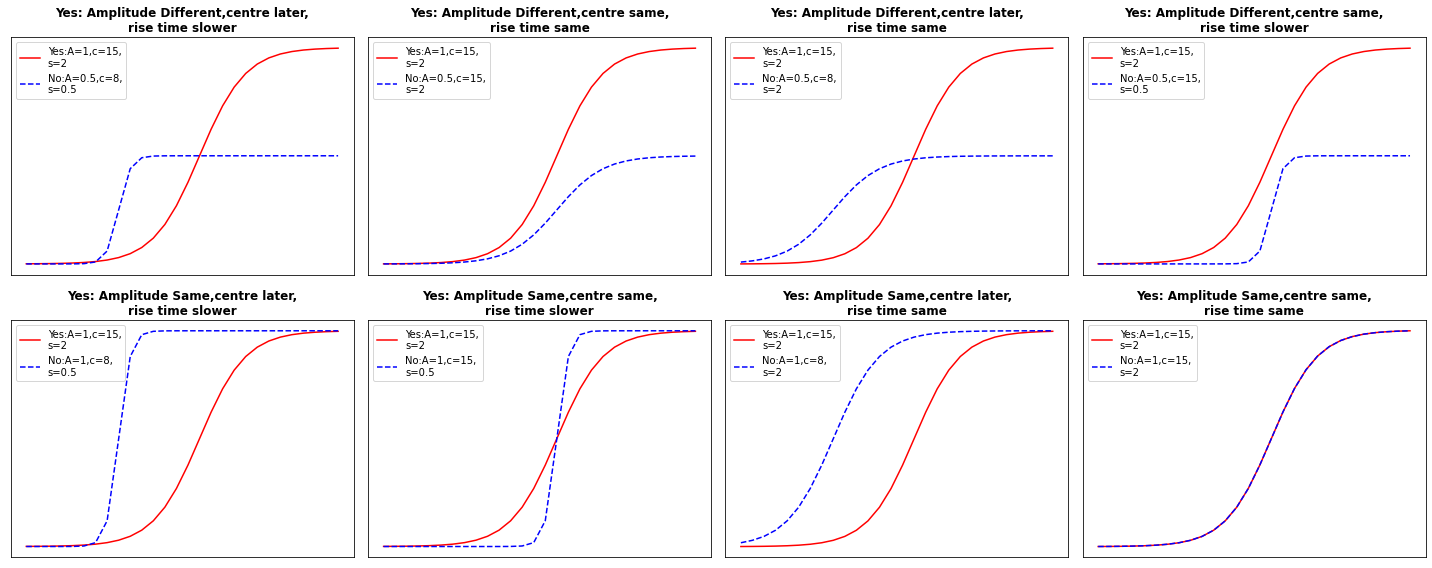

In [60]:
def logistic_function(x, A, c, s):
    return A*(1 - (1/ (1+np.exp((x-c)/s)) ))
    
x = np.arange(0,28)

plt.figure(1,figsize = (20,8))
for i in range(8):
    plt.subplot(2,4,i+1)
    
    AYes = 1
    if i< 4:
        ANo = .5
        Albl = 'Different'
    else:
        ANo = AYes
        Albl = 'Same'
        
    
    cYes = 15
    if i%2 ==1:
        cNo = cYes
        clbl = 'same'
    else:
        cNo = 8
        clbl = 'later'

    sYes = 2
    if i not in [1,2,6,7]:
        sNo = .5
        slbl = 'slower'
    else: 
        sNo = sYes
        slbl = 'same'

    plt.plot(x,logistic_function(x,AYes,cYes,sYes), label = f'Yes:A={AYes},c={cYes},\ns={sYes}', color = 'r')
    plt.plot(x,logistic_function(x,ANo,cNo,sNo), label = f'No:A={ANo},c={cNo},\ns={sNo}', color = 'b', ls = 'dashed')
    plt.title(f'Yes: Amplitude {Albl},centre {clbl},\nrise time {slbl}', fontweight = 'bold')
    plt.legend(loc='upper left')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [12]:
def sigmoid_sinefit(y,r2_thr,plot_fig):
    # computes the best fit using a sinusoidal function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    def logistic_function(x, A, c, s):
        return A*(1 - (1/ (1+np.exp((x-c)/s)) ))
    
    model = Model(logistic_function) + SineModel() # set function here
    
    model.set_param_hint('A', min=-1, max = 1)# set param range here for sigmoid fn
    model.set_param_hint('c', min=2, max = 28)
    model.set_param_hint('s', min=.1, max = 3)

    model.set_param_hint('amplitude', min = 1e-3,max = .5) # set param range here for sine fn (small value because
    #we're trying to model the fast small oscillations)
    model.set_param_hint('frequency', min = 2, max = 5) # to account for smaller variations (doesn't have to 
    #match with constraints of the fn "sinefit" above)
    
    params = model.make_params(A=max(y)-min(y), c=np.argmax(np.diff(y)), s = 1 , 
                               amplitude = (max(y)-min(y))/2, frequency = 2,
                               shift = np.pi/2 ) # set initial param values here
    
    result = model.fit(y, params, x=np.linspace(0,2*np.pi,28))
    param_keys = list(result.best_values.keys()) # E.g. A,freq,ph
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    if plot_fig:
        result.plot()
        plt.suptitle('Sinusoidal, Rsq='+str(np.round(r2,2)),fontweight = 'bold')
    #print(result.best_values)
    #if r2 > r2_thr:
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname]
    #else:
    #    params_best[:] = np.nan
        
    return params_best,param_keys, r2, result.aic,result

- combining sine and sigmoid function can sometimes help, but it seems to weigh the initial timepts kinda strongly and can often lead to bad fits. So leaving it out of the analyses and keeping to simple functions for now.

In [13]:
def gaussianfit(y,r2_thr,plot_fig):
    # computes the best fit using a gaussian function (for early peak-timecourses) for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    from lmfit.models import GaussianModel
    
    model = GaussianModel()  # set model here
    model.set_param_hint('amplitude', max = 1, min = -1) # set parameter ranges here
    model.set_param_hint('center', min = 2, max = 25)
    model.set_param_hint('sigma', min=-5, max = 5)
    
    params = model.make_params(amplitude = .5, center = np.argmax(np.diff(y)),
                               sigma = 1) # set initial param values here
    
    result = model.fit(y, params, x=np.arange(0,28))
    param_keys = list(result.best_values.keys()) # E.g. A,freq,ph
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    if plot_fig:
        result.plot()
        plt.suptitle('Gaussian, Rsq='+ str(np.round(r2,2)),fontweight = 'bold')    
    #print(result.best_values)
    #if r2 > r2_thr:
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname]
    #else:
    #    params_best[:] = np.nan
        
    return params_best,param_keys, r2, result.aic,result

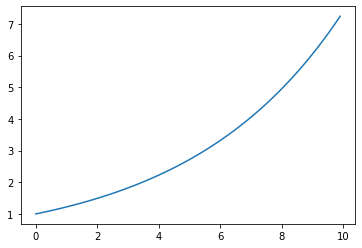

In [18]:
#### Work in progress - exponential fit

x = np.arange(0,10,.1)
A = 1
tau = 5
y = A* np.exp(x/tau)
plt.plot(x,y)


def expofit(y,r2_thr,plot_fig):
    # computes the best fit using a gaussian function (for early peak-timecourses) for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    from lmfit.models import ExponentialModel
    
    model = ExponentialModel()  # set model here
    #model.set_param_hint('amplitude', max = 1, min = -1) # set parameter ranges here
    #model.set_param_hint('decay', min = -10, max = 10, expr = '(decay>=1e-3) & (decay<=-1e-3)')
    model.set_param_hint('decay', expr = 'decay != 0')
    
    params = model.make_params(amplitude = .1, decay = 1) # set initial param values here
    
    result = model.fit(y, params, x=np.arange(0,28))
    param_keys = list(result.best_values.keys()) # E.g. A,freq,ph
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    if plot_fig:
        result.plot()
        plt.suptitle('Gaussian, Rsq='+ str(np.round(r2,2)),fontweight = 'bold')    
    #print(result.best_values)
    #if r2 > r2_thr:
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname]
    #else:
    #    params_best[:] = np.nan
        
    return params_best,param_keys, r2, result.aic,result

In [ ]:
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

for resp in ["AYes", "ANo"]:
    nodes = np.empty((268,))
    nodes[:] =np.nan
    rows = [int(i) for i in df1["Nodes"]]
    nodes[rows] = df_respbased[resp]
    img = roi_to_brain(pd.Series(nodes), mask_x)
    img.plot(colorbar=True, title = resp, cmap = 'RdBu_r')
    
for resp in ["cYes", "cNo"]:
    nodes = np.empty((268,))
    nodes[:] =np.nan
    rows = [int(i) for i in df1["Nodes"]]
    nodes[rows] = df_respbased[resp]
    img = roi_to_brain(pd.Series(nodes), mask_x)
    img.plot(colorbar=True, title = resp, cmap = 'RdBu_r')
    
for resp in ["sYes", "sNo"]:
    nodes = np.empty((268,))
    nodes[:] =np.nan
    rows = [int(i) for i in df_respbased["Nodes"]]
    nodes[rows] = df1[resp]
    img = roi_to_brain(pd.Series(nodes), mask_x)
    img.plot(colorbar=True, title = resp, cmap = 'RdBu_r')

### Other functions I explored:

In [ ]:
def linfit(y,r2_thr,plot_fig):
    # computes the best fit using a linear function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    model = LinearModel()  # set model here
    #model.set_param_hint('intercept', min=-5, max = 5) # set a parameter's range here
    
    params = model.make_params(intercept=y[0],slope = 1) # set initial parameter values here
    
    result = model.fit(y, params, x=np.arange(0,28))
    param_keys = list(result.best_values.keys()) # E.g. A,c,s for logisticfn
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    
    if plot_fig:
        result.plot()
        plt.suptitle('Linear, Rsq=' + str(np.round(r2,2)),fontweight = 'bold')
    #print(result.best_values)
    #if r2 > r2_thr:
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname] 
    #else:
    #    params_best[:] = np.nan
    return params_best, param_keys, r2, result.aic, result

In [ ]:
def loglinfit(y,r2_thr, plot_fig):
    # computes the best fit using a logistic + linear function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    # used this function for later yes/no curve fits that's why this function is written in a little more detail
    
    model = StepModel(form='logistic') + LinearModel() # set model here
    #model.set_param_hint('intercept', min=-5, max = 5) # set a parameter's range here
    model.set_param_hint('amplitude', min=-1, max = 1)
    model.set_param_hint('center', min=2, max = 28)
    model.set_param_hint('sigma', min=.1, max = 500)
    
    params = model.make_params(intercept=y[0], amplitude=max(y)-min(y),
                               center=np.argmax(np.diff(y)),
                                   sigma = 1 ) # set initial values here
    nparams = 5
    params_best = np.empty((5,))
    try:
        result = model.fit(y, params, x=np.arange(0,28))
        param_keys = list(result.best_values.keys()) # E.g. A,c,s for logisticfn
        param_keys.remove('form')
        
        r2 = fit_goodness_test(y, result)

        if plot_fig:
            result.plot()
            plt.suptitle('Linear+Log, Rsq=' + str(np.round(r2,2)),fontweight = 'bold')
            print(result.fit_report())
            print("Rsq: ",r2)
        #print(result.best_values)
        #if r2 > r2_thr:
        for pind,pname in enumerate(param_keys):
            params_best[pind] = result.best_values[pname]
        #else:
        #    params_best[:] = np.nan
    except:
        params_best[:] = np.nan
        param_keys = np.nan
        r2 = np.nan
        
        
    return params_best,param_keys, r2,result.aic, result

In [ ]:
def linsinefit(y,r2_thr,plot_fig):
    # computes the best fit using a sinusoidal function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    
    model = SineModel() + LinearModel() # set model here
    model.set_param_hint('amplitude', max = 2) # set parameter ranges here
    model.set_param_hint('frequency', max = 3)
    #model.set_param_hint('intercept', min=-5, max = 5)
    
    params = model.make_params(amplitude = 1, frequency = 1,
                               shift = 0, intercept=y[0],slope = 1 ) # set initial param values here
    
    result = model.fit(y, params, x=np.arange(0,28))
    param_keys = list(result.best_values.keys()) # E.g. A,freq,ph
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    if plot_fig:
        result.plot()
        plt.suptitle('Linear+Sinusoidal, Rsq='+ str(np.round(r2,2)),fontweight = 'bold')    
    #print(result.best_values)
    #if r2 > r2_thr:
    for pind,pname in enumerate(param_keys):
        params_best[pind] = result.best_values[pname]
    #else:
    #    params_best[:] = np.nan
        
    return params_best,param_keys, r2, result.aic, result

In [ ]:
# RUN THIS CELL
# logistic curve properties
# can explore the effect of A,c,s here

def logistic_function(x, A, c, s):
    return A*(1 - (1/ (1+np.exp((x-c)/s)) ))


x= np.arange(1,100)
A= 1#amplitude
c=x[int(len(x)/2)]#centre
s=3#standard dev
plt.plot(x,logistic_function(x, A, c, s))
A = 5
plt.plot(x,logistic_function(x, A, c, s))

In [152]:
def sigmoid(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

In [ ]:
def delayed_sin(x, step_size = .01, step_onset=int(len(x)/2), amp=.5, freq=1, phase=np.pi):
    
    y = np.zeros((len(x),))
    #print('x:',x)
    #print('amp:',amp)
    #print('freq:', freq)
    #print('phase:', phase)
    
    
    for i in range(len(x)):
        if i >= step_onset*180/np.pi:
            #x_rad = x[i]*np.pi/180.
            y[i] = step_size + amp * np.sin(freq*x[i]+phase)
            # print(y[i])
            
    #print('\ny:',y)
    return y

from lmfit.models import Model

node_ind = 210
y = mean_tc[node_ind,:]



model = Model(delayed_sin)
model.set_param_hint('step_size', min=-.5, max = .5)
model.set_param_hint('step_onset', min=2*np.pi/180, max = 20*np.pi*180)
model.set_param_hint('amp', min=0.01, max = 1)
model.set_param_hint('freq', min=.5, max = 2)
model.set_param_hint('phase', min=1e-10, max = 2*np.pi)
params = model.make_params(step_size = 0, step_onset=5*np.pi/180, A = max(y)-min(y), freq = 1, phase = np.pi/4)

result = model.fit(y, params, x=np.linspace(0,np.pi,28))

fit_goodness_test_fn(y,result.best_fit)

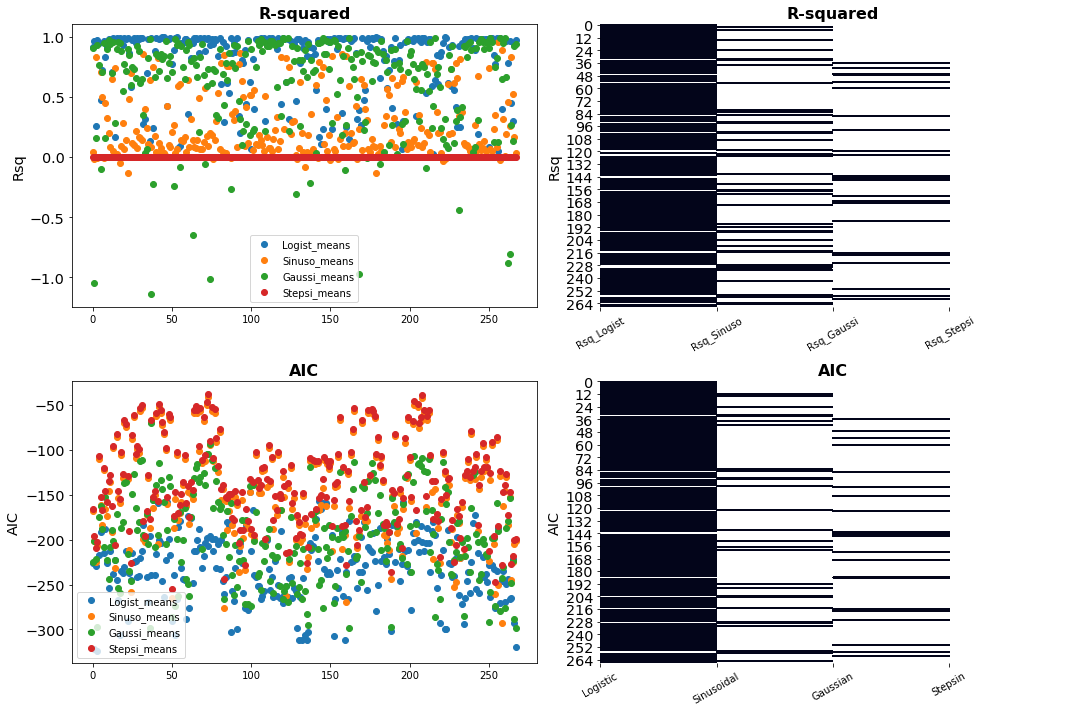

In [19]:
# plotting functionwise fit metrics (rsq and aic)

plt.figure(1,figsize = (15,10))
cols = [col for col in df if col.startswith('Rsq')]

plt.subplot(2,2,1)
plt.title('R-squared',fontsize = 16, fontweight = 'bold')
for colname in cols:
    plt.plot(range(268),df[colname].values,label = colname[4:10] + '_means',
            marker = 'o', linestyle = 'None')
plt.legend()

plt.ylabel ("Rsq", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
lbls = [i[4:] for i in cols]

plt.subplot(2,2,2)
plt.title('R-squared',fontsize = 16, fontweight = 'bold')
mat = df[cols].values
mat1 = np.empty_like(mat)
mat1[:] = np.nan
for row in range(mat.shape[0]):
    col = np.argmax(mat[row,:])
    mat1[row,col] = 1
sns.heatmap(mat1,cbar = False)
plt.ylabel ("Rsq", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
lbls = [i[:10] for i in cols]
plt.xticks(range(len(cols)), lbls, rotation = 30)
lbls = [i[4:] for i in cols]

plt.subplot(2,2,3)
plt.title('AIC', fontsize = 16, fontweight = 'bold')
cols = [col for col in df if col.startswith('AIC')]
for colname in cols:
    plt.plot(range(268),df[colname].values,label = colname[4:10] + '_means',
             marker = 'o', linestyle = 'None')

plt.ylabel ("AIC", fontsize = 'x-large')
plt.yticks(fontsize='x-large')

plt.legend(loc = 'lower left')


plt.subplot(2,2,4)
plt.title('AIC',fontsize = 16, fontweight = 'bold')
mat = df[cols].values
mat1 = np.empty_like(mat)
mat1[:] = np.nan
for row in range(mat.shape[0]):
    col = np.argmin(mat[row,:])
    mat1[row,col] = 1
sns.heatmap(mat1, cbar = False)#sns.heatmap(df_modelfits[cols].values,)
plt.ylabel ("AIC", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(range(len(cols)), lbls, rotation = 30)

plt.tight_layout()